In [1]:
import numpy as np
import os
import datetime as datetime
import pandas as pd


os.system('source /home/jackalak/heartbeat/cdf38_0-dist/bin/definitions.B')
os.environ["CDF_LIB"] = '/home/jackalak/heartbeat/cdf38_0-dist/lib'
from spacepy import pycdf
import matplotlib.pyplot as plt
from ovationpyme.ovation_prime import FluxEstimator,AverageEnergyEstimator,BinCorrector
from ovationpyme.ovation_utilities import calc_avg_solarwind
from ovationpyme.ovation_plotting import latlt2polar,polar2dial,pcolor_flux

import numpy as np
import pandas as pd
from datetime import timedelta

from nasaomnireader import omnireader

import ftplib
import os

import os
import datetime as datetime
import pickle
import glob
import tensorflow as tf
from tensorflow import keras
import datetime

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import tensorflow

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout
from sklearn import preprocessing
import tensorflow.keras.backend as K


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 
matplotlib.rc('font', **font)
from pylab import rcParams
rcParams['figure.figsize'] = 11, 8

import datetime
from os.path import isfile, join
from sys import getsizeof
from random import *

%matplotlib notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Input

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/nasaomnireader-0.1.0-py3.6.egg/nasaomnireader/__init__.py", line 5, in <module>
    from nasaomnireader.omnireader_config import config
ModuleNotFoundError: No module named 'nasaomnireader.omnireader_config'

Solar wind data files will be saved to /home/jackalak/.local/share/nasaomnireader


In [2]:
def download_omni_data(t_start, t_end):

    #--------------------------------------------------------#
    #	OMNI Data - includes solar wind, and geomag params   #
    #--------------------------------------------------------#

    #get OMNI data
    omniInt = omnireader.omni_interval(t_start,t_end,'5min', cdf_or_txt = 'txt')

    #print(omniInt.cdfs[0].vars) #prints all the variables available on omni

    epochs = omniInt['Epoch'] #time array for omni 5min data
    By,Bz,AE,SymH = omniInt['BY_GSM'],omniInt['BZ_GSM'],omniInt['AE_INDEX'], omniInt['SYM_H']
    AL, AU = omniInt['AL_INDEX'],omniInt['AU_INDEX']
    vsw,psw = omniInt['flow_speed'], omniInt['Pressure']
    borovsky_reader = omnireader.borovsky(omniInt)
    borovsky = borovsky_reader()
    #newell_reader = omnireader.newell(omniInt)
    #newell = newell_reader()

    def NewellCF_calc(v,bz,by):
        # v expected in km/s
        # b's expected in nT    
        NCF = np.zeros_like(v)
        NCF.fill(np.nan)
        bt = np.sqrt(by**2 + bz**2)
        bztemp = bz
        bztemp[bz == 0] = .001
        #Caculate clock angle (theta_c = t_c)
        tc = np.arctan2(by,bztemp)
        neg_tc = bt*np.cos(tc)*bz < 0 
        tc[neg_tc] = tc[neg_tc] + np.pi
        sintc = np.abs(np.sin(tc/2.))
        NCF = (v**1.33333)*(sintc**2.66667)*(bt**0.66667)
        return NCF


    newell = NewellCF_calc(vsw, Bz, By)


    # 	proton_flux_10MeV, proton_flux_30MeV, proton_flux_60MeV = omniInt['PR-FLX_10'], omniInt['PR-FLX_30'], omniInt['PR-FLX_60']


    #calculate clock angle
    clock_angle = np.degrees(np.arctan2( By,Bz))
    clock_angle[clock_angle < 0] = clock_angle[clock_angle<0] + 360.

    #print('Got 5 minutes data')

    omniInt_1hr = omnireader.omni_interval(t_start,t_end,'hourly', cdf_or_txt = 'txt')
    F107,KP = omniInt_1hr['F10_INDEX'], omniInt_1hr['KP']
    KP = pd.DataFrame(np.repeat(KP,12,axis=0))
    F107 = pd.DataFrame(np.repeat(F107,12,axis=0))



    #put all in a dataframe and save

    dataframe = pd.DataFrame()
    dataframe['Bz'] = Bz
    dataframe['By'] = By
    dataframe['Vsw'] = vsw
    dataframe['Vx'] = omniInt['Vx']
    dataframe['Psw'] = psw
    dataframe['AE'] = AE
    dataframe['AL'] = AL
    dataframe['AU'] = AU
    dataframe['SymH'] = SymH
    dataframe['Clock Angle'] = clock_angle
    dataframe['newell'] = newell
    dataframe['borovsky'] = borovsky
    dataframe['Kp'] = KP
    dataframe['F107'] = F107
    dataframe['PC'] = omniInt['PC_N_INDEX']
    dataframe['Bx'] = omniInt['BX_GSE']
    # 	dataframe = dataframe.replace(9999.99, np.nan) #replace 9999.99 with nans ??????????????

    return dataframe

from datetime import timedelta

# In[2]:


class t_hist():
    '''
    Class which takes solar wind data and creates some time history
    for some specific time.
    
    Input:
        Data ---------- A DataFrame of solar wind data at 5 minute
                        cadence and datetime index.
        Historic_time - The number of minutes into the past you
                        would like the hisotry for. (E.g. for 1hr ago
                        you would input 60 minutes).
        window_mins --- If averaging for the time history, then this
                        input specifies the window length, in minutes,
                        centred on the historic_time specified.
    '''
    def __init__(self,data,historic_time,window_mins):
        self.data = data
        self.time = historic_time
        self.window = window_mins
        
    def avg_hist(self):
        '''
        Function which returns a historic_time value, averaged over
        the window_mins.
        
        Output:
            - A dataframe of values of the time history.
        '''
        # Check that indices are datetime
        self.is_datetime()
        
        if self.time % 60:
            raise ValueError('Please choose a historic time value '+
                             'which correspond to an integer '+
                             'number of hours!')
        
        window_s = timedelta(minutes = self.time + self.window/2.0)
        # '+5' ensures that the window is closed on the right
        window_e = timedelta(minutes = self.time + 5 -
                             self.window/2.0)
        indices = self.data.index
        
        hist = [self.data[i-window_s : i-window_e].mean().values
                for i in indices]
        
        col_label = '_'+str(self.time/60.0)[0]+'hr'
        columns = [i+col_label for i in self.data.columns]
        
        th_df = pd.DataFrame(hist, index=indices,columns=columns)
        
        return th_df[th_df.index[0]+window_s:]
    
    def instant_hist(self):
        '''
        Function which returns an instantaneous historic_time value.
        
        Output:
            - A dataframe of instantaneous values corresponding to
              historic_time minutes in the past.
        '''
        # Check that indices are datetime
        self.is_datetime()
        
        if self.time % 5:
            raise ValueError('Please choose a historic time value '+
                             'which correspond to a multiple of 5 '+
                             'minutes!')
            
        t_offset = timedelta(minutes=self.time)
        indices = self.data.index
        

        hist = [self.data.loc[i-t_offset].values
                 for i in self.data.index
                 if i >= indices[0]+t_offset]
        
        if self.time < 60:
            if self.time >= 10:
                col_label = '_'+str(self.time)[0:2]+'min'
            else:
                col_label = '_'+str(self.time)[0]+'min'
        else:
            col_label = '_'+str(self.time/60.0)[0]+'hr_I'
        columns = [i+col_label for i in self.data.columns]
        return pd.DataFrame(hist, index=indices[int(self.time/5):],
                            columns=columns)
    
    def is_datetime(self):
        dt_type = pd.core.indexes.datetimes.DatetimeIndex
        if type(self.data.index) != dt_type:
            raise ValueError('Dataframe index is not '+
                             'in the correct datetime '+
                             'format')
        else:
            pass


# In[3]:

def cleaning_data(data,safe_cols=[],sigma_val=4):
    '''
    Function which removes data which is 'sigma_val' stdevs from
    the mean.

    Note: 4 sigma encompasses ~99.994% of the data.
          ~1 real piece of 5 min data is removed for
          every 55 days of such data (assuming Gaussian).

    Inputs:
    sigma_val - (float) number of standard deviations from the
                mean to consider as the limit of 'good' data.
    safe_cols - Columns in the data which one might like to
                keep without any changes (i.e., if there are
                no null values in the initial dataset etc.).

    Returns:
     - Cleaned solar wind data dataframe.
     - Dataframe of 'bad' solar wind data.
    '''

#   Initialising data and empty lists
    sw_df = data
    cleaned_cols = []
    trash_data = []
#   Looping through dataframe columns and removing 'bad' values
    for i in sw_df.columns:
        if i not in safe_cols:
            std = sw_df[i].std()
            mean = sw_df[i].mean()

            cleaned = sw_df[i][sw_df[i]<mean+std*sigma_val]
            trash = sw_df[i][sw_df[i]>=mean+std*sigma_val]

            cleaned_cols.append(cleaned)
            trash_data.append(trash)
        else:
            cleaned_cols.append(sw_df[i])
            trash_data.append([np.nan])
#   Initialising empty dataframes and appending data
    sw_c_df = pd.DataFrame()
    trash_df = pd.DataFrame()

    for i in range(len(sw_df.columns)):
#         sw_c_df[sw_df.columns[i]] = cleaned_cols[i]
#         sw_c_df = sw_c_df
        sw_c_df_temp = pd.DataFrame(cleaned_cols[i],
                                 columns=[sw_df.columns[i]])
        sw_c_df = pd.concat([sw_c_df,sw_c_df_temp], axis=1)

        trash_df_temp = pd.DataFrame(trash_data[i],
                                     columns=[sw_df.columns[i]])
        trash_df = pd.concat([trash_df,trash_df_temp], axis=1)

#   Checking if the trash data contains non-'bad' data.
    check_trash(trash_df)
    return (sw_c_df, trash_df)

#################################

def sw_interp(data,method='linear'):
    '''
    Function which interpolates NaN values in the cleaned
    data dataframe.

    See Pandas documentation for other methods.

    Input:
    method - method of interpolation.

    Return:
     - Cleaned, interpolated data.
    '''
    return data.interpolate(method=method)

#################################

def check_trash(trash_data):
    '''
    Function which checks to see if all the removed data
    is the 'bad' data fill value.

    Returns:
     - String detailing which parameters have had real
       removed from them.
    '''
    for i in trash_data.columns:
        if (trash_data[i].mean() <
            trash_data[i].max()):
            print('Some real data has been removed from: ',i)
        else:
            pass

# In[4]:

def time_history(data,auto=True):
    '''
    Function which calculates time history information
    given an input dataframe.
    
    Averages are centred on the respective time-history
    specified.
    
    Input:
    data - a Pandas DataFrame containing 5 minute cadence
           data.
           MUST HAVE DATETIME INDEX.
    auto - Whether or not to automatically clean the data.
           If not True, then the cleaning_data() and
           sw_interp() functions must be called individually
           and the results of sw_interp() should be the data
           fed to this function, time_history(). Set to false
           to retrieve the non-interpolated data and the trash
           data.
    
    Output:
    A concatenated DataFrame containing
        - the original data
        - t-6hrs (1hr avg)
        - t-5hrs (1hr avg)
        - t-3hrs (30min avg)
        - t-1hrs (30min avg)
        - t-45min (instant)
        - t-30min (instant)
        - t-15min (instant)
        - t-10min (instant)
        - t-5min (instant)
    '''
    if auto is True:
        c_data,t_data = cleaning_data(data,sigma_val=4,
                                  safe_cols=[None])
        c_i_data = sw_interp(c_data,method='linear')
        
        data = c_i_data
    else:
        pass
    return pd.concat((data,
                      t_hist(data,360,60).avg_hist(),
                      t_hist(data,300,60).avg_hist(),
                      t_hist(data,180,30).avg_hist(),
                      t_hist(data,60,30).avg_hist(),
                      t_hist(data,45,0).instant_hist(),
                      t_hist(data,30,0).instant_hist(),
                      t_hist(data,15,0).instant_hist(),
                      t_hist(data,10,0).instant_hist(),
                      t_hist(data,5,0).instant_hist()),axis=1)

import ftplib
import os

def _is_ftp_dir(ftp_handle, name, guess_by_extension=True):
    """ simply determines if an item listed on the ftp server is a valid directory or not """

    # if the name has a "." in the fourth to last position, its probably a file extension
    # this is MUCH faster than trying to set every file to a working directory, and will work 99% of time.
    if guess_by_extension is True:
        if name[-4] == '.':
            return False

    original_cwd = ftp_handle.pwd()     # remember the current working directory
    try:
        ftp_handle.cwd(name)            # try to set directory to new name
        ftp_handle.cwd(original_cwd)    # set it back to what it was
        return True
    except:
        return False


def _make_parent_dir(fpath):
    """ ensures the parent directory of a filepath exists """
    dirname = os.path.dirname(fpath)
    while not os.path.exists(dirname):
        try:
            os.mkdir(dirname)
            print("created {0}".format(dirname))
        except:
            _make_parent_dir(dirname)


def _download_ftp_file(ftp_handle, name, dest, overwrite,datetime_start,datetime_end):
    """ downloads a single file from an ftp server """
    _make_parent_dir(dest)
    
    if (name[-7:-1]!='SHA1SU'): #ignore SHA1SUM files
        month = int(name[-15:-13])
        day = int(name[-13:-11])
        year = int(name[-19:-15])
        base = datetime.datetime(year, month, day)
        if (datetime_start <= base <= datetime_end):

            if not os.path.exists(dest) or overwrite is True:
                with open(dest, 'wb') as f:
                    ftp_handle.retrbinary("RETR {0}".format(name), f.write)
                print("downloaded: {0}".format(dest))
            else:
                print("already exists: {0}".format(dest))


def _mirror_ftp_dir(ftp_handle, name, overwrite, guess_by_extension,datetime_start,datetime_end):
    """ replicates a directory on an ftp server recursively """
    for item in ftp_handle.nlst(name):
        if _is_ftp_dir(ftp_handle, item):
            _mirror_ftp_dir(ftp_handle, item, overwrite, guess_by_extension,datetime_start,datetime_end)
        else:
            _download_ftp_file(ftp_handle, item, item, overwrite,datetime_start,datetime_end)


def download_ftp_tree(ftp_handle, path, destination, datetime_start,datetime_end, overwrite=False, guess_by_extension=True):
    """
    Downloads an entire directory tree from an ftp server to the local destination

    :param ftp_handle: an authenticated ftplib.FTP instance
    :param path: the folder on the ftp server to download
    :param destination: the local directory to store the copied folder
    :param overwrite: set to True to force re-download of all files, even if they appear to exist already
    :param guess_by_extension: It takes a while to explicitly check if every item is a directory or a file.
        if this flag is set to True, it will assume any file ending with a three character extension ".???" is
        a file and not a directory. Set to False if some folders may have a "." in their names -4th position.
    """
    os.chdir(destination)
    _mirror_ftp_dir(ftp_handle, path, overwrite, guess_by_extension,datetime_start,datetime_end)
    
def  get_data(datetime_start,datetime_end,sc_id):

    years = {6:[1987], 7:[1987],8:[1987],9:[1988]
             ,12:[2000,2001,2002], 13:[2000,2001,2002,2003,2004,2005,2006,2007],14:[2000,2001,2002,2003,2004,2005],
             15:[2000,2001,2002,2003,2004,2005,2006,2007,2008,2009],
             16:[2010,2011,2012,2013,2014,2015], #year 2003-2009 is not accessible on site
             17:[2009,2010,2011,2012,2013,2014,2015],
             18:[2010,2011,2012,2013,2014,2015],#2009 not accessible
            } 
    
#     if !(years[sc_id].any() != datetime_start.year):
#         print('bad sc_id year combination')
#         exit()
    
    dmsp_feature_list = ['ELE_AVG_ENERGY','ELE_AVG_ENERGY_STD','ELE_TOTAL_ENERGY_FLUX','ELE_TOTAL_ENERGY_FLUX_STD',
                         'SC_AACGM_LAT',  'SC_AACGM_LON','SC_AACGM_LTIME',] 
    #                     'ION_AVG_ENERGY','ION_AVG_ENERGY_STD','ION_TOTAL_ENERGY_FLUX','ION_TOTAL_ENERGY_FLUX_STD','SC_GEOCENTRIC_LAT','SC_GEOCENTRIC_LON','SC_GEOCENTRIC_R']
    dmsp_feature_list_19 =['ELE_COUNTS_BKG','ELE_COUNTS_OBS','ELE_DIFF_ENERGY_FLUX','ELE_DIFF_ENERGY_FLUX_STD',
                      'CHANNEL_ENERGIES','ELE_COUNTS_BKG','ELE_COUNTS_OBS',]
    #                  'ELE_GEOMETRIC','ION_COUNTS_BKG','ION_COUNTS_OBS','ION_DIFF_ENERGY_FLUX','ION_DIFF_ENERGY_FLUX_STD','ION_GEOMETRIC',
    #                  'SC_ECI','SC_ECI_LABEL']

    import glob
    all_sc_df = pd.DataFrame()
    count = 0
    for ii in [sc_id]:
        sc_df = pd.DataFrame()
        print(ii)
        directory = 'pub/data/dmsp/dmspf'
        if ii <10:
            directory = directory + '0'
        directory = directory + str(ii) + '/ssj/precipitating-electrons-ions'
        for year in [datetime_start.year]:
            print(year)
            
            from ftplib import FTP_TLS
            ftp=FTP_TLS('cdaweb.gsfc.nasa.gov')
            ftp.login()
            ftp.dir()
            download_ftp_tree(ftp, directory, '.',datetime_start,datetime_end)
            
            file_list=glob.glob(directory + '/'+str(year)+'/*')
            
            
            for file in file_list:
                print(file)
                try:

                    count = count+1
                    month = int(file[-15:-13])
                    day = int(file[-13:-11])
                    base = datetime.datetime(year, month, day)
                    
                    if (datetime_start <= base <= datetime_end):
                        indices = np.array([base + datetime.timedelta(seconds=iii) for iii in range(0,60*24*60)])
                        df = pd.DataFrame(data=indices,columns=['index'])
                        cdf = pycdf.CDF(file)
                        count = count+1
                        for feature in dmsp_feature_list:
                            df[feature] = cdf[feature]

                        ch_energies = cdf['CHANNEL_ENERGIES']
#                         print(np.array(ch_energies))
#                         for i in range(0,19):
#                             print((ch_energies[i]))
                        ch_energies = np.flip((ch_energies[:]))
                        temp_jN = (pd.DataFrame(cdf['ELE_COUNTS_OBS'])- pd.DataFrame(cdf['ELE_COUNTS_BKG'])).values
                        df['ELE_TOTAL_COUNTS'] = temp_jN[:,0]*(ch_energies[1]-ch_energies[0])
                        + temp_jN[:,18]*(ch_energies[18]-ch_energies[17])
                        for i in range(1,18):
                            df['ELE_TOTAL_COUNTS'] = df['ELE_TOTAL_COUNTS']  +     temp_jN[:,i]*(ch_energies[i+1]-ch_energies[i-1])/2.

                        for i in range(0,19):
                            name = 'ELE_COUNT_'+str(i+1)
                            df[name]=temp_jN[:,i]
                        for i in range(0,19):
                            name = 'ELE_diff_'+str(i+1)
                            df[name]=cdf['ELE_DIFF_ENERGY_FLUX'][:,i]

                        df = df.set_index('index')
                        df.index = pd.to_datetime(df.index)

                        print('df',df.shape)#, df)
                        #Create a time window
                        df = df[df['ELE_TOTAL_ENERGY_FLUX'] > 0].dropna(subset=['ELE_TOTAL_ENERGY_FLUX'])

                         #Create a time window
                        sTimeIMF = datetime.datetime(year,month,day)
                        eTimeIMF = sTimeIMF + datetime.timedelta(hours = 24)

                        df_omni_5min = download_omni_data(sTimeIMF- datetime.timedelta(hours = 6),
                                                     eTimeIMF+ datetime.timedelta(hours = 6))
                        print('df_omni_5min',df_omni_5min.shape)#, df_omni_5min)
                        indices = np.array([sTimeIMF- datetime.timedelta(hours = 6)+ datetime.timedelta(minutes=5*iii) for iii in range(0,df_omni_5min.shape[0])])
                        print('indices',indices.shape)#, indices)

                        df_omni_5min = pd.DataFrame(data=df_omni_5min.values,columns=df_omni_5min.columns, index=indices)
                        print('df_omni_5min',df_omni_5min.shape)#, df_omni_5min)


                        # call time_history to clean up omnireader data        
                        df_omni_5min_cleaned = time_history(df_omni_5min)
                        print('df_omni_5min_cleaned',df_omni_5min_cleaned.shape)#,, df_omni_5min_cleaned)
                        df_omni_1min_cleaned = pd.DataFrame(np.repeat(df_omni_5min_cleaned.values,5*60,axis=0))
                        print('df_omni_5min_cleaned',df_omni_5min_cleaned.shape)#,, df_omni_5min_cleaned)

            #             #create the indices
                        indices = []
                        for index in df_omni_5min_cleaned.index:
                            for jj in range(0,60*5):
                                indices.append(index+ datetime.timedelta(seconds=jj))
                        print('indices',len(indices))#, indices)

                        df_omni_1min_cleaned = pd.DataFrame(data=df_omni_1min_cleaned.values,columns=df_omni_5min_cleaned.columns,
                                                            index=indices)    
                        print('df_omni_5min_cleaned',df_omni_5min_cleaned.shape)#, df_omni_5min_cleaned)

                        intersection_indices = df_omni_1min_cleaned.index.intersection(df.index)
                        print('intersection_indices',intersection_indices.shape)#,, intersection_indices)

                        df = df.loc[intersection_indices]
                        print('df',df.shape)#, df)
                        df_omni_1min_cleaned = df_omni_1min_cleaned.loc[intersection_indices]
                        print('df_omni_5min_cleaned',df_omni_5min_cleaned.shape)#, df_omni_5min_cleaned)

                        #combine Omni and DMSP data
                        for feature in df_omni_1min_cleaned.columns:
                            df[feature] = df_omni_1min_cleaned[feature]  

                        sc_df = pd.concat([sc_df,df])
                        print('sc_df',sc_df.shape)#, sc_df)
                except Exception as e: 
                    print('Error')
                    print(e)
                    print(file)


        

            sc_df['SC_ID']= ii

            #filescname = "./all_sc_df_1-sec_2010-" + str(ii) + ".pkl"
            #pickling_on = open(filescname,"wb")
            #pickle.dump(sc_df, pickling_on,protocol=4)

            all_sc_df = pd.concat([all_sc_df,sc_df])   
            #print(i, 'all_sc_df',all_sc_df.shape, all_sc_df)

    test=all_sc_df
    test['datetime']=test.index
    test=test.sort_values(by=['datetime'])
    test = test.set_index('datetime')

    # get rid of ones near equatoer
    test=test[np.abs(test['SC_AACGM_LAT'])>45]
    # swap by for southern hemisphere
    test.loc[test['SC_AACGM_LAT']<0 , 'By'] = -test.loc[test['SC_AACGM_LAT']<0 , 'By']
    #combine southern with northern hemisphere data
    test['SC_AACGM_LAT']=np.abs(test['SC_AACGM_LAT'])

    test['cos_SC_AACGM_LTIME']=np.cos(test['SC_AACGM_LTIME']*2*3.14159/24)
    test['sin_SC_AACGM_LTIME']=np.sin(test['SC_AACGM_LTIME']*2*3.14159/24)

    doy_loop = test.index.day
    ut_loop = test.index.hour*3600 + test.index.minute*60 + test.index.second
    test['sin_doy']= np.sin(2*np.pi*doy_loop/365.)
    test['cos_doy'] = np.cos(2*np.pi*doy_loop/365.)
    test['sin_ut'] = np.sin(2*np.pi*ut_loop/86400.)
    test['cos_ut'] = np.cos(2*np.pi*ut_loop/86400.)

    del doy_loop,ut_loop

    return test    



def plot_model(df_results, test):
    
    y_val_log = np.log10(test['ELE_TOTAL_ENERGY_FLUX'])
    
    plt.figure()
    plt.plot(y_val_log[:],alpha=0.5)
    plt.plot(df_results[:],alpha=0.5)
    plt.legend(['val', 'result'], loc='upper left')
    plt.show()


    plt.figure()
    plt.plot(10**y_val_log[:]*1.6e-6,alpha=0.5)
    plt.plot(10**df_results[:]*1.6e-6,alpha=0.5)
    plt.legend(['val', 'result'], loc='upper left')
    plt.show()
    
    start=int(y_val_log.shape[0]/2)
    plt.figure()
    plt.plot(y_val_log[start:2000+start],alpha=0.5)
    plt.plot(df_results[start:2000+start],alpha=0.5)
    plt.legend(['val', 'result'], loc='upper left')
    plt.show()
    
    plt.figure()
    plt.plot(10**y_val_log[start:2000+start]*1.6e-6,alpha=0.5)
    plt.plot(10**df_results[start:2000+start]*1.6e-6,alpha=0.5)
    plt.legend(['val', 'result'], loc='upper left')
    plt.show()
    
    

    minr = np.min(y_val_log.values)
    maxr = np.max(y_val_log.values)
    plt.figure()
    plt.hist(y_val_log.values,bins=200,alpha=0.5,range=(minr,maxr))
    plt.hist(df_results.values,bins=200,alpha=0.5,range=(minr,maxr))
    plt.legend(['val','result'], loc='upper left')
    plt.show()
    
    plt.figure()
    plt.hist(10**y_val_log.values*1.6e-6,bins=100, log=True,range=(10**minr*1.6e-6,10**maxr*1.6e-6),alpha=0.5)
    plt.hist(10**df_results.values*1.6e-6,bins=100, log=True,range=(10**minr*1.6e-6,10**maxr*1.6e-6),alpha=0.5)
    plt.legend(['val', 'result'], loc='upper left')
    plt.show()

    import matplotlib.colors as mcolors
    gamma = 0.2#[0.8, 0.5, 0.3]

    errors= y_val_log.values-df_results.values[:,0]
    plt.figure();
    plt.hist2d(test['SC_AACGM_LAT'].values, errors,
                  bins=50, norm=mcolors.PowerNorm(gamma))
    plt.title('Error density over SC_AACGM_LAT Bins')
    plt.xlabel('SC_AACGM_LAT')
    plt.ylabel('log10(y_true)-log10(y_pred)')
    plt.show()
    
    errors= y_val_log.values-df_results.values[:,0]
    bin_total = np.zeros((200))
    bin_error_total = np.zeros((200))
    for j in range(0,y_val_log.values.shape[0]):
        i = int((test['SC_AACGM_LAT'].values[j]-45)/((90-45)/200))
        if i < 200:
            bin_total[i] = bin_total[i]+1
            bin_error_total[i] = bin_error_total[i] + np.abs(errors[j])

    avg_error_over_hist = bin_error_total/bin_total
    plt.figure()
    plt.scatter(np.linspace(45,90,num=200),avg_error_over_hist)
    plt.title('Average Validation Error over SC_AACGM_LAT Bins')
    plt.show()


    bin_total = np.zeros((200))
    bin_error_total = np.zeros((200))
    for j in range(0,y_val_log.values.shape[0]):
        i = int((y_val_log[j]-minr)/((maxr-minr)/200))
        if i < 200:
            bin_total[i] = bin_total[i]+1
            bin_error_total[i] = bin_error_total[i] + np.abs(errors[j])

    avg_error_over_hist = bin_error_total/(bin_total+.00001)
    plt.figure()
    plt.scatter(np.linspace(minr,maxr,num=200),avg_error_over_hist)
    plt.title('Average Validation Error over target Bins')    
    plt.show()

    import matplotlib.colors as mcolors
    gamma = 0.2#[0.8, 0.5, 0.3]
    errors= y_val_log.values-df_results.values[:,0]

    plt.figure();
    plt.hist2d(y_val_log.values, errors,
                  bins=50, norm=mcolors.PowerNorm(gamma))
    plt.colorbar()
    plt.title('Error Density')
    plt.xlabel('log10(y_true)')
    plt.ylabel('log10(y_true-y_pred)')

    plt.show()
    

In [9]:
def plot_model_counts(df_results,test):
    
    y_val_log = np.log10(test['ELE_TOTAL_COUNTS'])

    
    plt.figure()
    plt.plot(y_val_log[:],alpha=0.5)
    plt.plot(df_results[:],alpha=0.5)
    plt.legend(['val', 'result'], loc='upper left')
    plt.show()


    plt.figure()
    plt.plot(10**y_val_log[:]*1.6e-6,alpha=0.5)
    plt.plot(10**df_results[:]*1.6e-6,alpha=0.5)
    plt.legend(['val', 'result'], loc='upper left')
    plt.show()

    
    start=int(y_val_log.shape[0]/2)
    plt.figure()
    plt.plot(y_val_log[start:2000+start],alpha=0.5)
    plt.plot(df_results[start:2000+start],alpha=0.5)
    plt.legend(['val', 'result'], loc='upper left')
    plt.show()
    
    plt.figure()
    plt.plot(10**y_val_log[start:2000+start]*1.6e-6)
    plt.plot(10**df_results[start:2000+start]*1.6e-6)
    plt.legend(['val', 'result'], loc='upper left')
    plt.show()

    minr = np.min(y_val_log.values)
    maxr = np.max(y_val_log.values)
    plt.figure()
    plt.hist(y_val_log.values,bins=200,alpha=0.5,range=(minr,maxr))
    plt.hist(df_results.values,bins=200,alpha=0.5,range=(minr,maxr))
    plt.legend(['val','result'], loc='upper left')
    plt.show()
    
    plt.figure()
    plt.hist(10**y_val_log.values*1.6e-6,bins=100, log=True,range=(10**minr*1.6e-6,10**maxr*1.6e-6),alpha=0.5)
    plt.hist(10**df_results.values*1.6e-6,bins=100, log=True,range=(10**minr*1.6e-6,10**maxr*1.6e-6),alpha=0.5)
    plt.legend(['val', 'result'], loc='upper left')
    plt.show()

    import matplotlib.colors as mcolors
    gamma = 0.2#[0.8, 0.5, 0.3]

    errors= y_val_log.values-df_results.values[:,0]
    plt.figure();
    plt.hist2d(test['SC_AACGM_LAT'].values, errors,
                  bins=50, norm=mcolors.PowerNorm(gamma))
    plt.title('Error density over SC_AACGM_LAT Bins')
    plt.xlabel('SC_AACGM_LAT')
    plt.ylabel('log10(y_true)-log10(y_pred)')
    plt.show()
    
    plt.figure()
    bin_total = np.zeros((200))
    bin_error_total = np.zeros((200))
    for j in range(0,y_val_log.values.shape[0]):
        i = int((test['SC_AACGM_LAT'].values[j]-45)/((90-45)/200))
        if i < 200:
            bin_total[i] = bin_total[i]+1
            bin_error_total[i] = bin_error_total[i] + np.abs(errors[j])

    avg_error_over_hist = bin_error_total/bin_total
    plt.scatter(np.linspace(45,90,num=200),avg_error_over_hist)
    plt.scatter(np.linspace(45,90,num=200),avg_error_over_hist)

    plt.title('Average Validation Error over SC_AACGM_LAT Bins')
    plt.show()

    plt.figure()
    bin_total = np.zeros((200))
    bin_error_total = np.zeros((200))
    for j in range(0,y_val_log.values.shape[0]):
        i = int((y_val_log[j]-minr)/((maxr-minr)/200))
        if i < 200:
            bin_total[i] = bin_total[i]+1
            bin_error_total[i] = bin_error_total[i] + np.abs(errors[j])

    avg_error_over_hist = bin_error_total/(bin_total+.00001)
    plt.scatter(np.linspace(minr,maxr,num=200),avg_error_over_hist)
    plt.title('Average Validation Error over target Bins')    
    plt.show()

    errors= y_val_log.values-df_results.values[:,0]

    plt.figure();
    plt.hist2d(y_val_log.values, errors,
                  bins=50, norm=mcolors.PowerNorm(gamma))
    plt.colorbar()
    plt.title('Error Density')
    plt.xlabel('log10(y_true)')
    plt.ylabel('log10(y_true)-log10(y_pred)')

    plt.show()
    
def plot_channels(df_results_all,test):

    for k in range(0,19):
        print(k)
        df_results = pd.DataFrame(data=df_results_all.values[:,k], index = test.index)
        y_val_log = np.log10(pd.DataFrame(data=test['ELE_COUNT_'+str(k+1)].values, index = test.index)+1)


        plt.figure()
        plt.plot(y_val_log[:],alpha=0.5)
        plt.plot(df_results[:],alpha=0.5)
        plt.legend(['val', 'result'], loc='upper left')
        plt.show()


        plt.figure()
        plt.plot(10**y_val_log[:]*1.6e-6,alpha=0.5)
        plt.plot(10**df_results[:]*1.6e-6,alpha=0.5)
        plt.legend(['val', 'result'], loc='upper left')
        plt.show()


        start=int(y_val_log.shape[0]/2)
        plt.figure()
        plt.plot(y_val_log[start:2000+start],alpha=0.5)
        plt.plot(df_results[start:2000+start],alpha=0.5)
        plt.legend(['val', 'result'], loc='upper left')
        plt.show()

        plt.figure()
        plt.plot(10**y_val_log[start:2000+start]*1.6e-6,alpha=0.5)
        plt.plot(10**df_results[start:2000+start]*1.6e-6,alpha=0.5)
        plt.legend(['val', 'result'], loc='upper left')
        plt.show()

        minr = np.min(y_val_log.values)
        maxr = np.max(y_val_log.values)
        plt.figure()
        plt.hist(y_val_log.values,bins=200,alpha=0.5,range=(minr,maxr))
        plt.hist(df_results.values,bins=200,alpha=0.5,range=(minr,maxr))
        plt.legend(['val','result'], loc='upper left')
        plt.show()

        plt.figure()
        plt.hist(10**y_val_log.values*1.6e-6,bins=100, log=True,range=(10**minr*1.6e-6,10**maxr*1.6e-6),alpha=0.5)
        plt.hist(10**df_results.values*1.6e-6,bins=100, log=True,range=(10**minr*1.6e-6,10**maxr*1.6e-6),alpha=0.5)
        plt.legend(['val', 'result'], loc='upper left')
        plt.show()

        import matplotlib.colors as mcolors
        gamma = 0.2#[0.8, 0.5, 0.3]

        errors= y_val_log.values[:,0]-df_results.values[:,0]
        plt.figure();
        plt.hist2d(test['SC_AACGM_LAT'].values, errors,
                      bins=50, norm=mcolors.PowerNorm(gamma))
        plt.title('Error density over SC_AACGM_LAT Bins')
        plt.xlabel('SC_AACGM_LAT')
        plt.ylabel('log10(y_true)-log10(y_pred)')
        plt.show()

        plt.figure()
        bin_total = np.zeros((200))
        bin_error_total = np.zeros((200))
        for j in range(0,y_val_log.values.shape[0]):
            i = int((test['SC_AACGM_LAT'].values[j]-45)/((90-45)/200))
            if i < 200:
                bin_total[i] = bin_total[i]+1
                bin_error_total[i] = bin_error_total[i] + np.abs(errors[j])

        avg_error_over_hist = bin_error_total/bin_total
        plt.scatter(np.linspace(45,90,num=200),avg_error_over_hist)
        plt.scatter(np.linspace(45,90,num=200),avg_error_over_hist)

        plt.title('Average Validation Error over SC_AACGM_LAT Bins')
        plt.show()

        plt.figure()
        bin_total = np.zeros((200))
        bin_error_total = np.zeros((200))
        for j in range(0,y_val_log.values.shape[0]):
            i = int((y_val_log.values[j]-minr)/((maxr-minr)/200))
            if i < 200:
                bin_total[i] = bin_total[i]+1
                bin_error_total[i] = bin_error_total[i] + np.abs(errors[j])

        avg_error_over_hist = bin_error_total/(bin_total+.00001)
        plt.scatter(np.linspace(minr,maxr,num=200),avg_error_over_hist)
        plt.title('Average Validation Error over target Bins')    
        plt.show()

        plt.figure();
        plt.hist2d(y_val_log.values[:,0], errors,
                      bins=50, norm=mcolors.PowerNorm(gamma))
        plt.colorbar()
        plt.title('Error Density')
        plt.xlabel('log10(y_true)')
        plt.ylabel('log10(y_true)-log10(y_pred)')

        plt.show()

def plot_channels_total(df_results_all,test):               

    df_results = df_results_all
    y_val_log = pd.DataFrame(data=np.log10(test[['ELE_COUNT_1','ELE_COUNT_2', 'ELE_COUNT_3', 'ELE_COUNT_4', 'ELE_COUNT_5', 'ELE_COUNT_6', 'ELE_COUNT_7', 'ELE_COUNT_8', 'ELE_COUNT_9', 'ELE_COUNT_10', 'ELE_COUNT_11', 'ELE_COUNT_12', 'ELE_COUNT_13', 'ELE_COUNT_14', 'ELE_COUNT_15', 'ELE_COUNT_16', 'ELE_COUNT_17', 'ELE_COUNT_18', 'ELE_COUNT_19']].values+1)
        , index = test.index)
    ch_energies = np.array([30000.0,20400.0,13900.0,9450.0,6460.0,4400.0,3000.0,2040.0,
                        1392.0,949.0,646.0,440.0,300.0,204.0,139.0,95.0,65.0,44.0,30.0])
    ch_energies = np.flip((ch_energies[:]))
    #need to fix this latter to add first channel back in
    ELE_TOTAL_COUNTS = 10**(df_results.values[:,0])*(ch_energies[1]-ch_energies[0])
    + 10**(df_results.values[:,18])*(ch_energies[18]-ch_energies[17])
    for i in range(1,18):
        ELE_TOTAL_COUNTS = ELE_TOTAL_COUNTS +     10**(df_results.values[:,i])*(ch_energies[i+1]-ch_energies[i-1])/2.
    ELE_TOTAL_COUNTS= pd.DataFrame(data=np.log10(np.reshape(ELE_TOTAL_COUNTS,(ELE_TOTAL_COUNTS.shape[0])) ), index = test.index)

    ELE_TOTAL_COUNTS_val = 10**(y_val_log.values[:,0])*(ch_energies[1]-ch_energies[0])
    + 10**(y_val_log.values[:,18])*(ch_energies[18]-ch_energies[17])
    for i in range(1,18):
        ELE_TOTAL_COUNTS_val = ELE_TOTAL_COUNTS_val +     10**(y_val_log.values[:,i])*(ch_energies[i+1]-ch_energies[i-1])/2.

    y_val_log = np.log10(pd.DataFrame(data=(np.reshape(ELE_TOTAL_COUNTS_val,(ELE_TOTAL_COUNTS_val.shape[0]) )), index = test.index))

    df_results = ELE_TOTAL_COUNTS


    plt.figure()
    plt.plot(y_val_log[:],alpha=0.5)
    plt.plot(df_results[:],alpha=0.5)
    plt.legend(['val', 'result'], loc='upper left')
    plt.show()


    plt.figure()
    plt.plot(10**y_val_log[:]*1.6e-6,alpha=0.5)
    plt.plot(10**df_results[:]*1.6e-6,alpha=0.5)
    plt.legend(['val', 'result'], loc='upper left')
    plt.show()


    start=int(y_val_log.shape[0]/2)
    plt.figure()
    plt.plot(y_val_log[start:2000+start],alpha=0.5)
    plt.plot(df_results[start:2000+start],alpha=0.5)
    plt.legend(['val', 'result'], loc='upper left')
    plt.show()

    plt.figure()
    plt.plot(10**y_val_log[start:2000+start]*1.6e-6,alpha=0.5)
    plt.plot(10**df_results[start:2000+start]*1.6e-6,alpha=0.5)
    plt.legend(['val', 'result'], loc='upper left')
    plt.show()

    minr = 0#np.min(y_val_log.values)
    maxr = 9#np.max(y_val_log.values)
    plt.figure()
    plt.hist(y_val_log.values,bins=200,alpha=0.5,range=(minr,maxr))
    plt.hist(df_results.values,bins=200,alpha=0.5,range=(minr,maxr))
    plt.legend(['val','result',], loc='upper left')
    plt.show()

    plt.figure()
    plt.hist(10**y_val_log.values*1.6e-6,bins=100, log=True,range=(10**minr*1.6e-6,10**maxr*1.6e-6),alpha=0.5)
    plt.hist(10**df_results.values*1.6e-6,bins=100, log=True,range=(10**minr*1.6e-6,10**maxr*1.6e-6),alpha=0.5)
    plt.legend(['val', 'result'], loc='upper left')
    plt.show()

    import matplotlib.colors as mcolors
    gamma = 0.2#[0.8, 0.5, 0.3]

    errors= y_val_log.values[:,0]-df_results.values[:,0]
    plt.figure();
    plt.hist2d(test['SC_AACGM_LAT'].values, errors,
                  bins=50, norm=mcolors.PowerNorm(gamma))
    plt.title('Error density over SC_AACGM_LAT Bins')
    plt.xlabel('SC_AACGM_LAT')
    plt.ylabel('log10(y_true)-log10(y_pred)')
    plt.show()

    plt.figure()
    bin_total = np.zeros((200))
    bin_error_total = np.zeros((200))
    for j in range(0,y_val_log.values.shape[0]):
        i = int((test['SC_AACGM_LAT'].values[j]-45)/((90-45)/200))
        if i < 200:
            bin_total[i] = bin_total[i]+1
            bin_error_total[i] = bin_error_total[i] + np.abs(errors[j])

    avg_error_over_hist = bin_error_total/bin_total
    plt.scatter(np.linspace(45,90,num=200),avg_error_over_hist)
    plt.scatter(np.linspace(45,90,num=200),avg_error_over_hist)

    plt.title('Average Validation Error over SC_AACGM_LAT Bins')
    plt.show()

    plt.figure()
    bin_total = np.zeros((200))
    bin_error_total = np.zeros((200))
    for j in range(0,y_val_log.values.shape[0]):
        i = int((y_val_log.values[j]-minr)/((maxr-minr)/200))
        if i < 200:
            bin_total[i] = bin_total[i]+1
            bin_error_total[i] = bin_error_total[i] + np.abs(errors[j])

    avg_error_over_hist = bin_error_total/(bin_total+.00001)
    plt.scatter(np.linspace(minr,maxr,num=200),avg_error_over_hist)
    plt.title('Average Validation Error over target Bins')    
    plt.show()

    plt.figure();
    plt.hist2d(y_val_log.values[:,0], errors,
                  bins=50, norm=mcolors.PowerNorm(gamma))
    plt.colorbar()
    plt.title('Error Density')
    plt.xlabel('log10(y_true)')
    plt.ylabel('log10(y_true)-log10(y_pred)')

    plt.show()

    return ELE_TOTAL_COUNTS.values
    
    

def plot_hemisphere(scalar_X, model, features, test):

    mark= ['s', 'o', 'D', 'v']
    max_val = 13
    min_val = 7.5

    %matplotlib inline
    plt.ioff()

    for i in range(0,test.shape[0]):

        # using the variable axs for multiple Axes
        fig= plt.figure(figsize=(12,10))


        ax3 = plt.subplot2grid((2,2), (0,0), colspan=2,rowspan=1)

        ax4 = plt.subplot2grid((2,2), (1,0), rowspan=1,colspan=1,polar=True)
        ax5 = plt.subplot2grid((2,2), (1, 1), rowspan=1,colspan=1,polar=True)




        mlatgridN = np.linspace(90,45,num=90)
        mltgridN =  np.linspace(0,24,num=96)                   

        #################################
        #
        #ML model
        ##########################
        model_input = np.zeros((90,96,len(features)))
        flux = np.zeros((mlatgridN.shape[0], mltgridN.shape[0]))


        for j in range(0,mlatgridN.shape[0]):
            for k in range(0,mltgridN.shape[0]):        
                #calc cos and sin
                rads = mltgridN[k]*15*3.14159/180.
                model_input[j,k,:]=test[features].values[i,:]
                model_input[j,k,7]=np.cos(rads)
                model_input[j,k,6]=np.sin(rads)
                model_input[j,k,0]=mlatgridN[j]
        shaped = np.reshape(model_input,(90*96,len(features)))
        X_val_scaled = scaler_X.transform(shaped)
        #get auroral region and flux
        flux = np.reshape(model.predict(X_val_scaled),(90,96))

        pcolor_kwargs = {'cmap':'gnuplot','vmin':min_val,'vmax':max_val}
        mappableN = pcolor_flux(ax5,mlatgridN,mltgridN,flux,'N',**pcolor_kwargs)

        ax5.set_title('Predicted Electron Precipitation Energy Flux (Neural Net)',fontweight="bold", fontsize='medium',pad=10)


        ax5.set_theta_zero_location('S')
        theta_label_values = np.array([0.,3.,6.,9.,12.,15.,18.,21.])*180./12
        theta_labels = ['%d:00' % (int(th/180.*12)) for th in theta_label_values.flatten().tolist()]
        ax5.set_thetagrids(theta_label_values,labels=theta_labels)

        r_label_values = 90.-np.array([80.,70.,60.,50.])
        r_labels = [r'$%d^{o}$' % (int(90.-rv)) for rv in r_label_values.flatten().tolist()]
        ax5.set_rgrids(r_label_values,labels=r_labels)
        ax5.set_rlim([0.,45.])
    #     ax5.scatter(( np.arctan2(df_val['sin_SC_AACGM_LTIME'][t_range[i]],df_val['cos_SC_AACGM_LTIME'][t_range[i]]) ),
    #                (90.-(df_val['SC_AACGM_LAT'][t_range[i]])))



        ###########################3
        # Ovation
        ########################
        dt = test.index[i]
        print(dt)
        auroral_types = ['diff','mono','wave','ions']
        # axS = f.add_subplot(122,projection='polar')
        for jj in range(0,3):
            atype = auroral_types[jj]
            jtype ="energy"
            bincorrect = True
            combine_hemispheres = True
            dtstr = dt.strftime('%Y%m%d %H:%M')
            if jtype=='average energy':
                estimator = AverageEnergyEstimator(atype)
                get_precip_for_time = estimator.get_eavg_for_time
            else:
                estimator = FluxEstimator(atype,jtype)
                get_precip_for_time = estimator.get_flux_for_time


            tflux_kwargs = {'combine_hemispheres':combine_hemispheres,
                            'return_dF':True}
            fluxtupleN = get_precip_for_time(dt,hemi='N',**tflux_kwargs)
            mlatgridN,mltgridN,fluxgridN,newell_coupling = fluxtupleN
            fluxtupleS = get_precip_for_time(dt,hemi='S',**tflux_kwargs)
            mlatgridS,mltgridS,fluxgridS,newell_coupling = fluxtupleS

            if bincorrect:
                bcN = BinCorrector(mlatgridN,mltgridN)
                fluxgridN = bcN.fix(fluxgridN)
                bcS = BinCorrector(mlatgridS,mltgridS)
                fluxgridS = bcS.fix(fluxgridS)
                print("Correction Applied")

            if jj== 0:
                fluxgridN_sum = fluxgridN
                fluxgridS_sum = fluxgridS
            else:
                fluxgridN_sum = fluxgridN_sum+fluxgridN
                fluxgridS_sum = fluxgridN_sum+fluxgridS

        pcolor_kwargs = {'cmap':'gnuplot','vmin':min_val,'vmax':max_val}
        mappableN = pcolor_flux(ax4,mlatgridN,mltgridN,np.log10(fluxgridN_sum/1.60218e-12),'N',**pcolor_kwargs)

        ax4.set_title('Predicted Electron Precipitation Energy Flux (OVATION Pyme)',pad =10,fontweight="bold", fontsize='medium')


        ax4.set_theta_zero_location('S')
        theta_label_values = np.array([0.,3.,6.,9.,12.,15.,18.,21.])*180./12
        theta_labels = ['%d:00' % (int(th/180.*12)) for th in theta_label_values.flatten().tolist()]
        ax4.set_thetagrids(theta_label_values,labels=theta_labels,fontsize='medium', )

        r_label_values = 90.-np.array([80.,70.,60.,50.])
        r_labels = [r'$%d^{o}$' % (int(90.-rv)) for rv in r_label_values.flatten().tolist()]
        ax4.set_rgrids(r_label_values,labels=r_labels)
        ax4.set_rlim([0.,45.])
    #     ax4.scatter(( np.arctan2(df_val['sin_SC_AACGM_LTIME'][t_range[i]],df_val['cos_SC_AACGM_LTIME'][t_range[i]]) ),
    #                (90.-(df_val['SC_AACGM_LAT'][t_range[i]])))            

        plt.colorbar(mappableN,ax=ax5,label='Log10 Total Flux [eV/cm^2/ster/s]')




        ax4.scatter(np.ones((20))*3.14159/2 ,
                   np.linspace(0,40,20)      )     
        ax5.scatter(np.ones((20))*3.14159/2 ,
                   np.linspace(0,45,20 )     )     


        ax3.set_title('Log Scale Electron Precipitation Energy Flux [Log10 eV/cm^2/ster/s]'+' '+str(dt),fontweight="bold")
        ax3.scatter(np.linspace(90,50,80),np.log10(fluxgridN_sum[:,19]/1.60218e-12), marker=mark[2])
        ax3.scatter(np.linspace(90,45,90),flux[:,int(96/4)], marker=mark[3])
        ax3.legend(['OVATION Pyme model','neural net: 0.5 deg / Mlat'])
        ax3.set_ylim(top=max_val,bottom=min_val)
        #ax3.set_xlim(right=df_val.index[t_range_all[-1]])



        fig.tight_layout() 
        plt.show()
#         name = 'figures/fig_models_high_res_'+str(i) + '.png'
#         fig.savefig(name,dpi=400)


def plot_hemisphere2(scaler_X, model, features, test):

    mark= ['s', 'o', 'D', 'v']

    y_val_log = np.log10(test['ELE_TOTAL_ENERGY_FLUX']+.0001)

    num = test.shape[0]
    
    %matplotlib inline
    plt.ioff()
    ovation_val = []
    result_val = []
    

    for i in range(0,num):
        

       #################################
        #
        #ML model
        ##########################
        mlatgridN = np.linspace(90,45,num=90)
        mltgridN =  np.linspace(0,24,num=96)  
        model_input = np.zeros((90,96,len(features)))
        flux = np.zeros((mlatgridN.shape[0], mltgridN.shape[0]))


        for j in range(0,mlatgridN.shape[0]):
            for k in range(0,mltgridN.shape[0]):        
                #calc cos and sin
                rads = mltgridN[k]*15*3.14159/180.
                model_input[j,k,:]=test[features].values[i,:]
                model_input[j,k,7]=np.cos(rads)
                model_input[j,k,6]=np.sin(rads)
                model_input[j,k,0]=mlatgridN[j]
        shaped = np.reshape(model_input,(90*96,len(features)))
        X_val_scaled = scaler_X.transform(shaped)
        #get auroral region and flux
        flux = np.reshape(model.predict(X_val_scaled),(90,96))


        ###########################3
        # Ovation
        ########################
        dt = test.index[i]
        auroral_types = ['diff','mono','wave','ions']
        for jj in range(0,3):
            atype = auroral_types[jj]
            jtype ="energy"
            bincorrect = True
            combine_hemispheres = True
            dtstr = dt.strftime('%Y%m%d %H:%M')
            if jtype=='average energy':
                estimator = AverageEnergyEstimator(atype)
                get_precip_for_time = estimator.get_eavg_for_time
            else:
                estimator = FluxEstimator(atype,jtype)
                get_precip_for_time = estimator.get_flux_for_time


            tflux_kwargs = {'combine_hemispheres':combine_hemispheres,
                            'return_dF':True}
            fluxtupleN = get_precip_for_time(dt,hemi='N',**tflux_kwargs)
            mlatgridN,mltgridN,fluxgridN,newell_coupling = fluxtupleN
            fluxtupleS = get_precip_for_time(dt,hemi='S',**tflux_kwargs)
            mlatgridS,mltgridS,fluxgridS,newell_coupling = fluxtupleS

            if bincorrect:
                bcN = BinCorrector(mlatgridN,mltgridN)
                fluxgridN = bcN.fix(fluxgridN)
                bcS = BinCorrector(mlatgridS,mltgridS)
                fluxgridS = bcS.fix(fluxgridS)
                print("Correction Applied")

            if jj== 0:
                fluxgridN_sum = fluxgridN
                fluxgridS_sum = fluxgridS
            else:
                fluxgridN_sum = fluxgridN_sum+fluxgridN
                fluxgridS_sum = fluxgridN_sum+fluxgridS

       
        pt = i
        result_val.append( 
            flux[int((90-test['SC_AACGM_LAT'][pt])/45*90),int((test['SC_AACGM_LTIME'][pt])/24*96)] )
        if  test['SC_AACGM_LAT'][pt] <= 50:
            ovation_val.append( fluxgridN_sum[0,int((test['SC_AACGM_LTIME'][pt])/24*96)] )
        else:
            ovation_val.append( 
                fluxgridN_sum[int((90-test['SC_AACGM_LAT'][pt])/40*80),int((test['SC_AACGM_LTIME'][pt])/24*96)] )

    fig= plt.figure(figsize=(12,20))
    ax3 = plt.subplot2grid((4,2), (0,0), colspan=2,rowspan=1)
    ax4 = plt.subplot2grid((4,2), (1,0), rowspan=1,colspan=1,polar=True)
    ax5 = plt.subplot2grid((4,2), (1, 1), rowspan=1,colspan=1,polar=True)
    ax6 = plt.subplot2grid((4,2), (2,0), colspan=2,rowspan=1)
    ax7 = plt.subplot2grid((4,2), (3,0), colspan=2,rowspan=1)
        

    pcolor_kwargs = {'cmap':'gnuplot','vmin':7.5,'vmax':13}
    mappableN = pcolor_flux(ax4,mlatgridN,mltgridN,np.log10(fluxgridN_sum/1.60218e-12),'N',**pcolor_kwargs)
      
    ax4.set_title('Predicted Electron Precipitation Energy Flux (OVATION Pyme)',pad =10,fontweight="bold", fontsize='medium')
    ax4.set_theta_zero_location('S')
    theta_label_values = np.array([0.,3.,6.,9.,12.,15.,18.,21.])*180./12
    theta_labels = ['%d:00' % (int(th/180.*12)) for th in theta_label_values.flatten().tolist()]
    ax4.set_thetagrids(theta_label_values,labels=theta_labels,fontsize='medium', )

    r_label_values = 90.-np.array([80.,70.,60.,50.])
    r_labels = [r'$%d^{o}$' % (int(90.-rv)) for rv in r_label_values.flatten().tolist()]
    ax4.set_rgrids(r_label_values,labels=r_labels)
    ax4.set_rlim([0.,45.])
    plt.colorbar(mappableN,ax=ax5,label='Log10 Total Flux [eV/cm^2/ster/s]')


    mlatgridN = np.linspace(90,45,num=90)
    mltgridN =  np.linspace(0,24,num=96)  
    mappableN = pcolor_flux(ax5,mlatgridN,mltgridN,flux,'N',**pcolor_kwargs)

    ax5.set_title('Predicted Electron Precipitation Energy Flux (Neural Net)',fontweight="bold", fontsize='medium',pad=10)
    ax5.set_theta_zero_location('S')
    theta_label_values = np.array([0.,3.,6.,9.,12.,15.,18.,21.])*180./12
    theta_labels = ['%d:00' % (int(th/180.*12)) for th in theta_label_values.flatten().tolist()]
    ax5.set_thetagrids(theta_label_values,labels=theta_labels)

    r_label_values = 90.-np.array([80.,70.,60.,50.])
    r_labels = [r'$%d^{o}$' % (int(90.-rv)) for rv in r_label_values.flatten().tolist()]
    ax5.set_rgrids(r_label_values,labels=r_labels)
    ax5.set_rlim([0.,45.])
    
    ax4.scatter(test['SC_AACGM_LTIME'][i]/24*2*3.14159,90-test['SC_AACGM_LAT'][i])     
    ax5.scatter(test['SC_AACGM_LTIME'][i]/24*2*3.14159,90-test['SC_AACGM_LAT'][i])     
    ax3.set_title('Log Scale Electron Precipitation Energy Flux [Log10 eV/cm^2/ster/s]'+' '+str(dt),fontweight="bold")
    ax3.scatter(test['SC_AACGM_LAT'][0:i+1],np.log10(np.array(ovation_val)/1.60218e-12), marker=mark[1])
    ax3.scatter(test['SC_AACGM_LAT'][0:i+1],result_val, marker=mark[2])
    ax3.scatter(test['SC_AACGM_LAT'][0:i+1],y_val_log[0:i+1], marker=mark[3])
    ax3.legend(['OVATION Pyme model','neural net: 0.5 deg / Mlat','measured value'])
    ax3.set_xlabel('SC_AACGM_LAT')

    ax6.set_title('Log Scale Electron Precipitation Energy Flux [Log10 eV/cm^2/ster/s]'+' '+str(dt),fontweight="bold")
    ax6.scatter(test['SC_AACGM_LTIME'][0:i+1],np.log10(np.array(ovation_val)/1.60218e-12), marker=mark[1])
    ax6.scatter(test['SC_AACGM_LTIME'][0:i+1],result_val, marker=mark[2])
    ax6.scatter(test['SC_AACGM_LTIME'][0:i+1],y_val_log[0:i+1], marker=mark[3])
    ax6.set_xlabel('SC_AACGM_LTIME')
    ax6.legend(['OVATION Pyme model','neural net: 0.5 deg / Mlat','measured value'])

    ax7.set_title('Log Scale Electron Precipitation Energy Flux [Log10 eV/cm^2/ster/s]'+' '+str(dt),fontweight="bold")
    ax7.scatter(test.index[0:i+1],np.log10(np.array(ovation_val)/1.60218e-12), marker=mark[1])
    ax7.scatter(test.index[0:i+1],result_val, marker=mark[2])
    ax7.scatter(test.index[0:i+1],y_val_log[0:i+1], marker=mark[3])
    ax7.legend(['OVATION Pyme model','neural net: 0.5 deg / Mlat','measured value'])

    fig.tight_layout() 
    plt.show()

        
        
    return ovation_val


def plot_hemisphere3(scaler_X, model, features, test):

    mark= ['s', 'o', 'D', 'v']

    y_val_log = np.log10(test['ELE_TOTAL_ENERGY_FLUX']+.0001)

    num = test.shape[0]
    
    %matplotlib inline
    plt.ioff()
    ovation_val = []
    result_val = []
    

    for i in range(0,num):

        fig= plt.figure(figsize=(12,20))
        ax3 = plt.subplot2grid((2,2), (0,0), colspan=2,rowspan=1)
        ax4 = plt.subplot2grid((2,2), (1,0), rowspan=1,colspan=1,polar=True)
        ax5 = plt.subplot2grid((2,2), (1, 1), rowspan=1,colspan=1,polar=True)
        

       #################################
        #
        #ML model
        ##########################
        mlatgridN = np.linspace(90,45,num=90)
        mltgridN =  np.linspace(0,24,num=96)  
        model_input = np.zeros((90,96,len(features)))
        flux = np.zeros((mlatgridN.shape[0], mltgridN.shape[0]))


        for j in range(0,mlatgridN.shape[0]):
            for k in range(0,mltgridN.shape[0]):        
                #calc cos and sin
                rads = mltgridN[k]*15*3.14159/180.
                model_input[j,k,:]=test[features].values[i,:]
                model_input[j,k,7]=np.cos(rads)
                model_input[j,k,6]=np.sin(rads)
                model_input[j,k,0]=mlatgridN[j]
        shaped = np.reshape(model_input,(90*96,len(features)))
        X_val_scaled = scaler_X.transform(shaped)
        #get auroral region and flux
        flux = np.reshape(model.predict(X_val_scaled),(90,96))


        pcolor_kwargs = {'cmap':'gnuplot','vmin':7.5,'vmax':13}
        mappableN = pcolor_flux(ax5,mlatgridN,mltgridN,flux,'N',**pcolor_kwargs)

        ax5.set_title('Predicted Electron Precipitation Energy Flux (Neural Net)',fontweight="bold", fontsize='medium',pad=10)
        ax5.set_theta_zero_location('S')
        theta_label_values = np.array([0.,3.,6.,9.,12.,15.,18.,21.])*180./12
        theta_labels = ['%d:00' % (int(th/180.*12)) for th in theta_label_values.flatten().tolist()]
        ax5.set_thetagrids(theta_label_values,labels=theta_labels)

        r_label_values = 90.-np.array([80.,70.,60.,50.])
        r_labels = [r'$%d^{o}$' % (int(90.-rv)) for rv in r_label_values.flatten().tolist()]
        ax5.set_rgrids(r_label_values,labels=r_labels)
        ax5.set_rlim([0.,45.])


        ###########################3
        # Ovation
        ########################
        dt = test.index[i]
        auroral_types = ['diff','mono','wave','ions']
        for jj in range(0,3):
            atype = auroral_types[jj]
            jtype ="energy"
            bincorrect = True
            combine_hemispheres = True
            dtstr = dt.strftime('%Y%m%d %H:%M')
            if jtype=='average energy':
                estimator = AverageEnergyEstimator(atype)
                get_precip_for_time = estimator.get_eavg_for_time
            else:
                estimator = FluxEstimator(atype,jtype)
                get_precip_for_time = estimator.get_flux_for_time


            tflux_kwargs = {'combine_hemispheres':combine_hemispheres,
                            'return_dF':True}
            fluxtupleN = get_precip_for_time(dt,hemi='N',**tflux_kwargs)
            mlatgridN,mltgridN,fluxgridN,newell_coupling = fluxtupleN
            fluxtupleS = get_precip_for_time(dt,hemi='S',**tflux_kwargs)
            mlatgridS,mltgridS,fluxgridS,newell_coupling = fluxtupleS

            if bincorrect:
                bcN = BinCorrector(mlatgridN,mltgridN)
                fluxgridN = bcN.fix(fluxgridN)
                bcS = BinCorrector(mlatgridS,mltgridS)
                fluxgridS = bcS.fix(fluxgridS)
                print("Correction Applied")

            if jj== 0:
                fluxgridN_sum = fluxgridN
                fluxgridS_sum = fluxgridS
            else:
                fluxgridN_sum = fluxgridN_sum+fluxgridN
                fluxgridS_sum = fluxgridN_sum+fluxgridS

        mappableN = pcolor_flux(ax4,mlatgridN,mltgridN,np.log10(fluxgridN_sum/1.60218e-12),'N',**pcolor_kwargs)

        ax4.set_title('Predicted Electron Precipitation Energy Flux (OVATION Pyme)',pad =10,fontweight="bold", fontsize='medium')
        ax4.set_theta_zero_location('S')
        theta_label_values = np.array([0.,3.,6.,9.,12.,15.,18.,21.])*180./12
        theta_labels = ['%d:00' % (int(th/180.*12)) for th in theta_label_values.flatten().tolist()]
        ax4.set_thetagrids(theta_label_values,labels=theta_labels,fontsize='medium', )

        r_label_values = 90.-np.array([80.,70.,60.,50.])
        r_labels = [r'$%d^{o}$' % (int(90.-rv)) for rv in r_label_values.flatten().tolist()]
        ax4.set_rgrids(r_label_values,labels=r_labels)
        ax4.set_rlim([0.,45.])
        plt.colorbar(mappableN,ax=ax5,label='Log10 Total Flux [eV/cm^2/ster/s]')

           
        ax4.scatter(test['SC_AACGM_LTIME'][i]/24*2*3.14159,90-test['SC_AACGM_LAT'][i])     
        ax5.scatter(test['SC_AACGM_LTIME'][i]/24*2*3.14159,90-test['SC_AACGM_LAT'][i])     
 
       
        pt = i
        result_val.append( 
            flux[int((90-test['SC_AACGM_LAT'][pt])/45*90),int((test['SC_AACGM_LTIME'][pt])/24*96)] )
        if  test['SC_AACGM_LAT'][pt] <= 50:
            ovation_val.append( fluxgridN_sum[0,int((test['SC_AACGM_LTIME'][pt])/24*96)] )
        else:
            ovation_val.append( 
                fluxgridN_sum[int((90-test['SC_AACGM_LAT'][pt])/40*80),int((test['SC_AACGM_LTIME'][pt])/24*96)] )


        ax3.set_title('Log Scale Electron Precipitation Energy Flux [Log10 eV/cm^2/ster/s]'+' '+str(dt),fontweight="bold")
        ax3.scatter(test.index[0:i+1],np.log10(np.array(ovation_val)/1.60218e-12), marker=mark[1])
        ax3.scatter(test.index[0:i+1],result_val, marker=mark[2])
        ax3.scatter(test.index[0:i+1],y_val_log[0:i+1], marker=mark[3])
        ax3.legend(['OVATION Pyme model','neural net: 0.5 deg / Mlat','measured value'])

        ax3.set_ylim(top=13.5,bottom=7.5)
        ax3.set_xlim(right=test.index[-1])

        fig.tight_layout() 
        name = 'figures/movie_'+str(i) + '.png'
        fig.savefig(name,dpi=200)
    
        
    plt.show()


In [4]:

def custom_loss(y_true, y_pred):
    

    loss = K.mean( 
        2.5*(y_true-y_pred)*(y_true-y_pred)
        *K.cast(K.greater(y_true,11.5),'float32')*K.cast(K.less_equal(y_pred,11.5),'float32') +
        5*(y_true-y_pred)*(y_true-y_pred) 
        *K.cast(K.greater(y_true,12.),'float32')*K.cast(K.less_equal(y_pred,12.0),'float32') +
        10*(y_true-y_pred)*(y_true-y_pred)
        *K.cast(K.greater(y_true,12.5),'float32')*K.cast(K.less_equal(y_pred,12.5),'float32')  
        +
        10*(y_true-y_pred)*(y_true-y_pred)
        *K.cast(K.greater(y_true,12.75),'float32')*K.cast(K.less_equal(y_pred,12.75),'float32')  
        +
        10*(y_true-y_pred)*(y_true-y_pred)
        *K.cast(K.greater(y_true,13.),'float32')*K.cast(K.less_equal(y_pred,13.),'float32')  
    )             
                 
            
    loss =  loss+K.mean((y_true-y_pred)*(y_true-y_pred))

    return loss

features=['SC_AACGM_LAT', 'SC_ID', 'sin_ut',
                             'cos_ut', 'sin_doy', 'cos_doy', 'sin_SC_AACGM_LTIME', 'cos_SC_AACGM_LTIME',
                             'F107', 'AE', 'AL', 'AU', 'SymH', 
                             'F107_6hr', 'AE_6hr', 'AL_6hr', 'AU_6hr', 'SymH_6hr',
                              'F107_5hr', 'AE_5hr', 'AL_5hr', 'AU_5hr', 'SymH_5hr', 
                             'F107_3hr', 'AE_3hr', 'AL_3hr', 'AU_3hr', 'SymH_3hr', 
                             'F107_1hr', 'AE_1hr', 'AL_1hr', 'AU_1hr', 'SymH_1hr']
                             
filename='tail_loss_new_pipeline_33'
model = tensorflow.keras.models.load_model(filename, custom_objects={'custom_loss': custom_loss})

with open ('scalar_X_33_new_DB.pkl', 'rb') as f:
    scaler_X =pickle.load(f)

In [5]:
test = get_data( datetime.datetime(2013, 3, 17),datetime.datetime(2013, 3, 17),17)   
test=test.dropna()

17
2013
lrwxrwxrwx   1 rcandey  cdaweb         18 Sep 26  2012 000_readme.txt -> /pub/000_readme.txt
lrwxrwxrwx   1 rcandey  cdaweb         18 May  5  2017 000test -> /pub/000_readme.txt
lrwxrwxrwx   1 rcandey  cdaweb         17 Oct  5  2018 datasets.json -> /pub/datasets.json
lrwxrwxrwx   1 tkovalic cdaweb         24 Sep 25  2012 filelist.gz -> /pub/catalogs/filelist.gz
lrwxrwxrwx   1 tkovalic cdaweb         30 Sep 25  2012 filelist.patch.gz -> /pub/catalogs/filelist.patch.gz
lrwxrwxrwx   1 tkovalic cdaweb         21 Sep 25  2012 ls-lR.gz -> /pub/catalogs/ls-lR.gz
lrwxrwxrwx   1 tkovalic cdaweb         27 Sep 25  2012 ls-lR.patch.gz -> /pub/catalogs/ls-lR.patch.gz
drwxrwxr-x  10 tkovalic cdaweb         14 Nov 10 11:56 pub
-rwxr-xr--   1 tkovalic cdaweb       1457 Sep 27  2019 robots.txt
already exists: pub/data/dmsp/dmspf17/ssj/precipitating-electrons-ions/2013/dmsp-f17_ssj_precipitating-electrons-ions_20130317_v1.1.2.cdf
pub/data/dmsp/dmspf17/ssj/precipitating-electrons-ions/2013/dms

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in less



df_omni_5min (432, 16)
indices (432,)
df_omni_5min (432, 16)
df_omni_5min_cleaned (432, 160)
df_omni_5min_cleaned (432, 160)
indices 129600
df_omni_5min_cleaned (432, 160)
intersection_indices (81881,)
df (81881, 46)
df_omni_5min_cleaned (432, 160)
sc_df (81881, 206)


1387/1387 [==============================] - 2s 1ms/step - loss: 1.2607 - mean_squared_error: 1.0240
[1.2606943845748901, 1.0239557027816772]


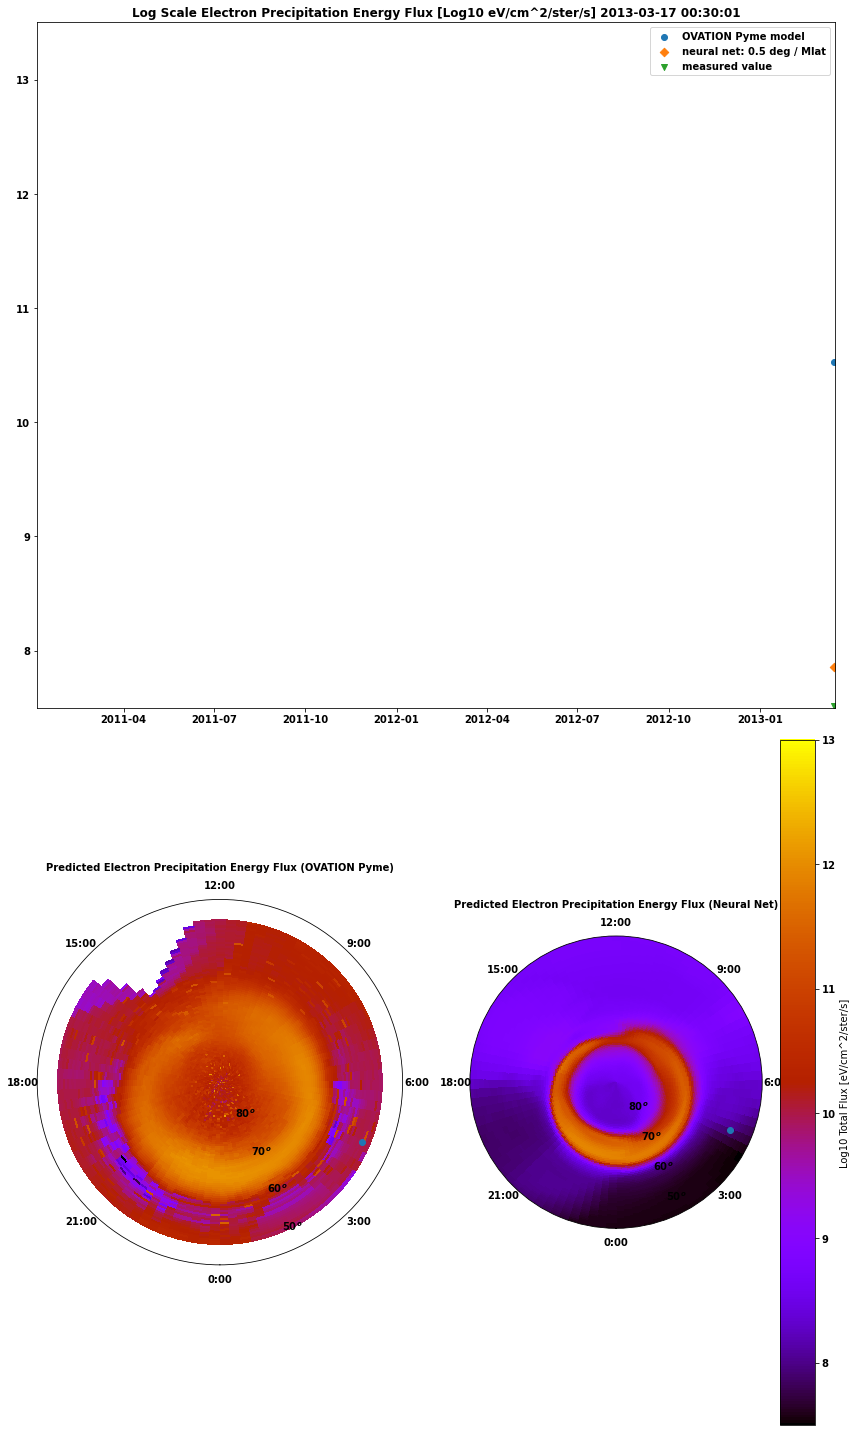

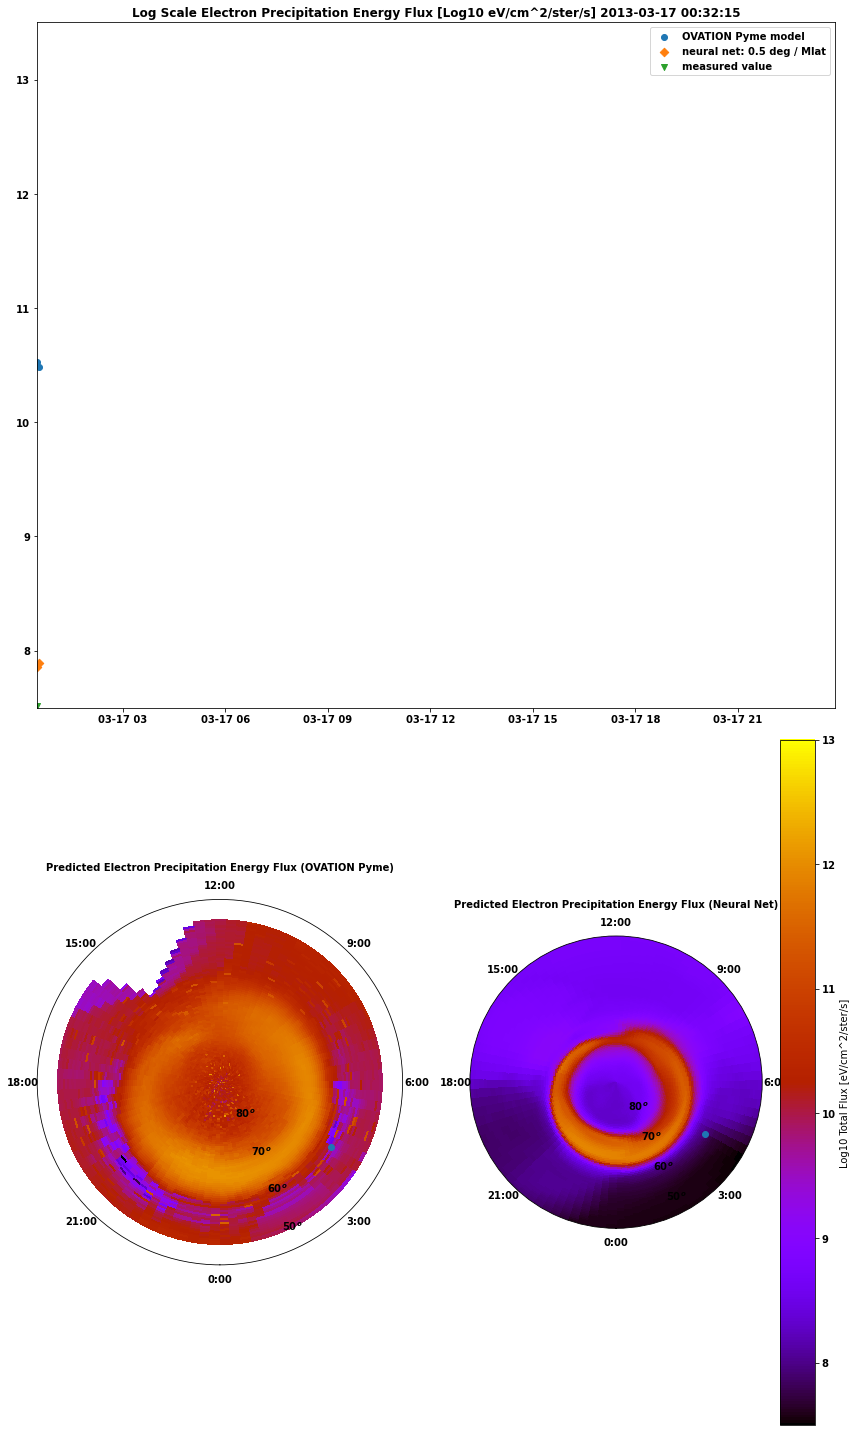

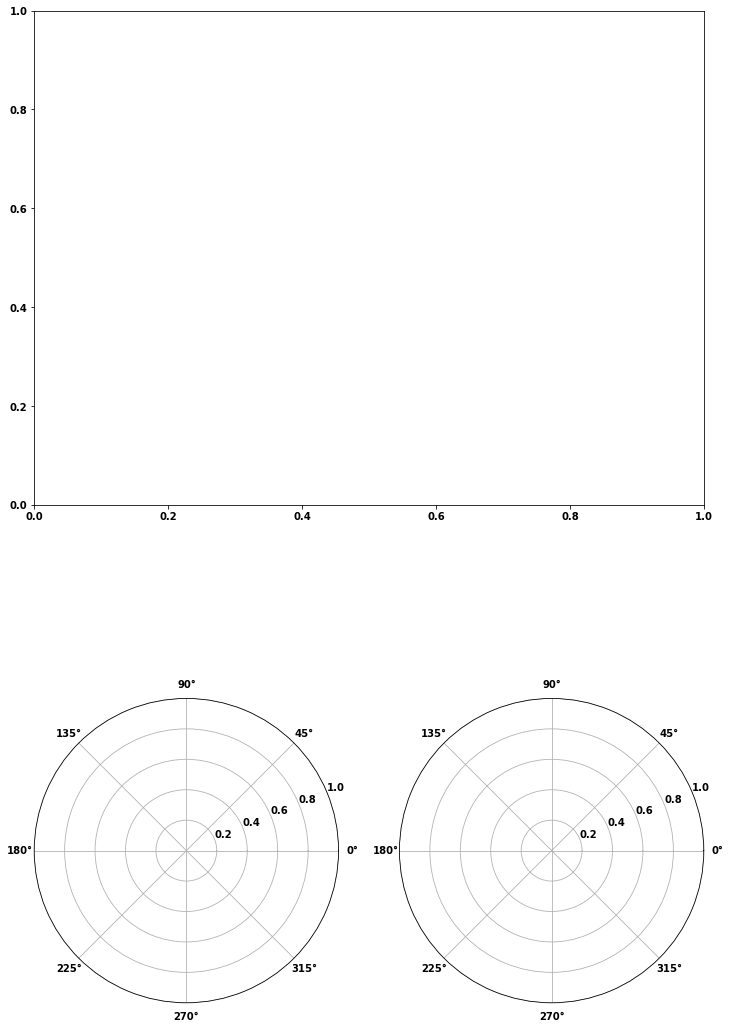

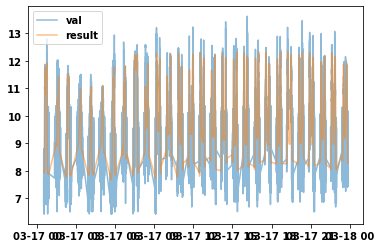

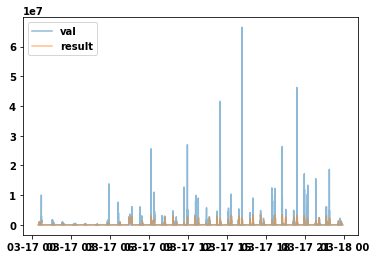

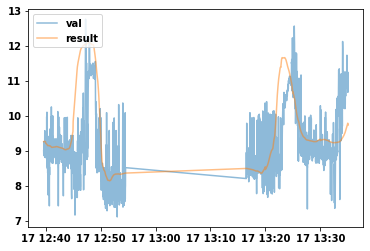

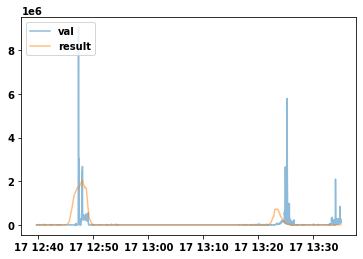

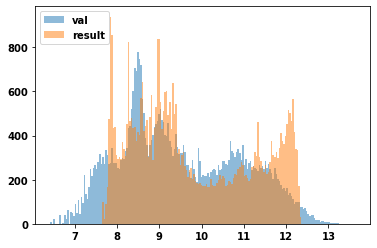

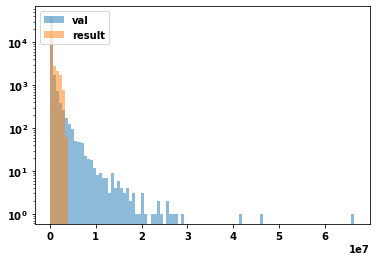

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


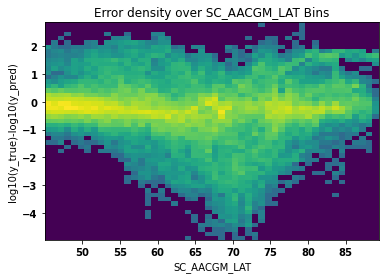

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:649: RuntimeWarning: invalid value encountered in true_divide


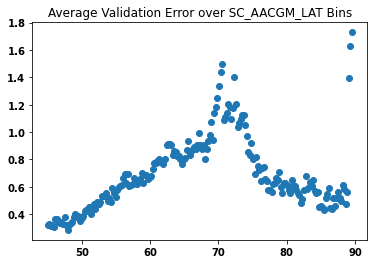

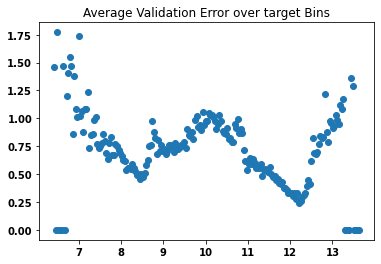

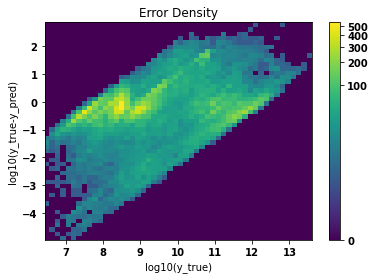

In [16]:
print(model.evaluate(scaler_X.transform(test[features].values),np.log10(test['ELE_TOTAL_ENERGY_FLUX'].values+.0001)))
results_flux = model.predict( scaler_X.transform(test[features].values))
df_results = pd.DataFrame(data=results_flux, index = test.index)
    
plot_model(df_results,test)


(5, 213)


/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


2013-03-17 00:30:01
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:434: RuntimeWarning: divide by zero encountered in log10
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Correction Applied


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


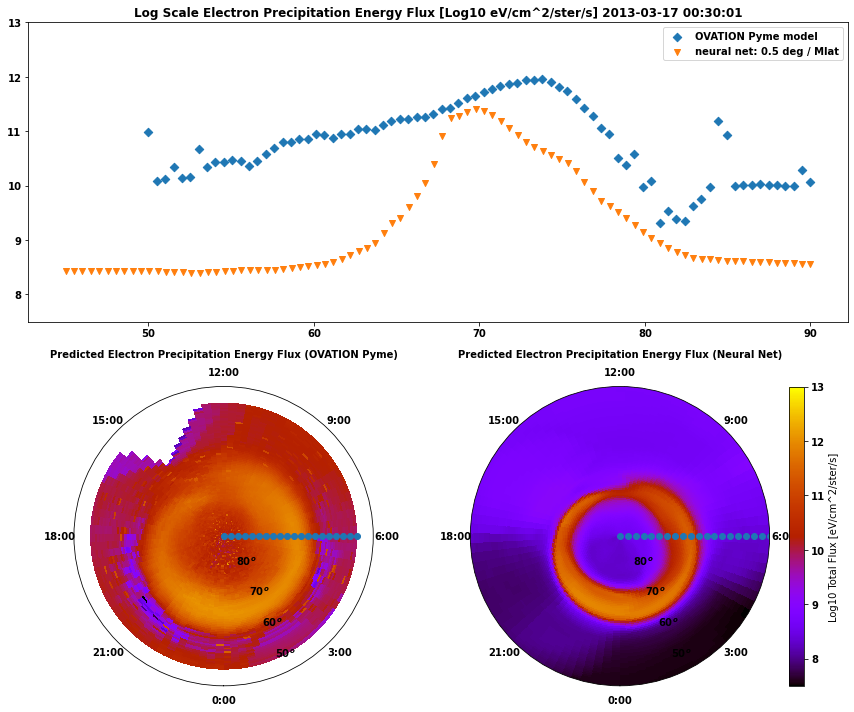

/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


2013-03-17 06:37:00
Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:434: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:463: RuntimeWarning: divide by zero encountered in log10


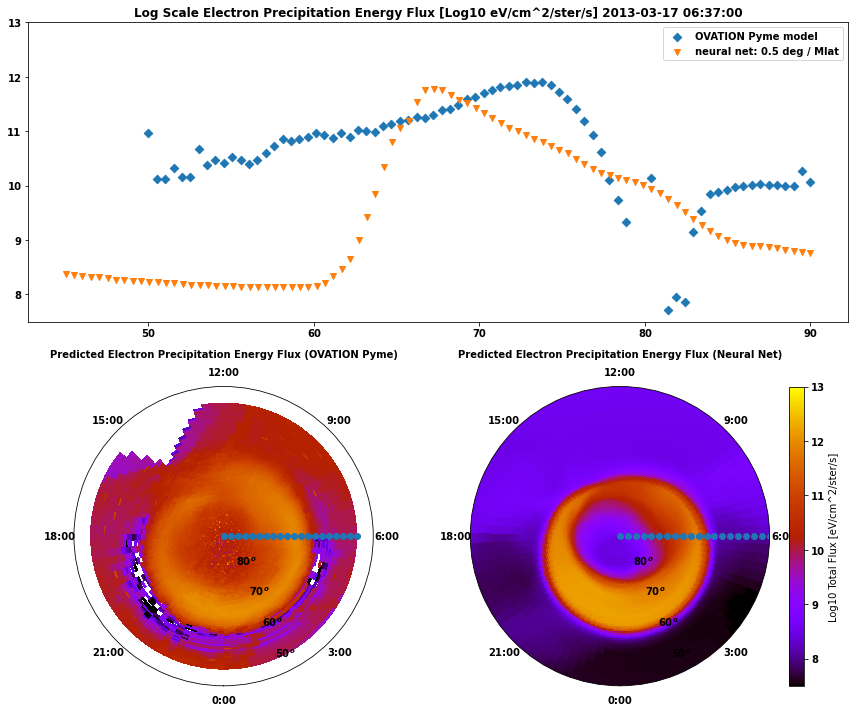

/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


2013-03-17 12:29:55
Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:434: RuntimeWarning: divide by zero encountered in log10


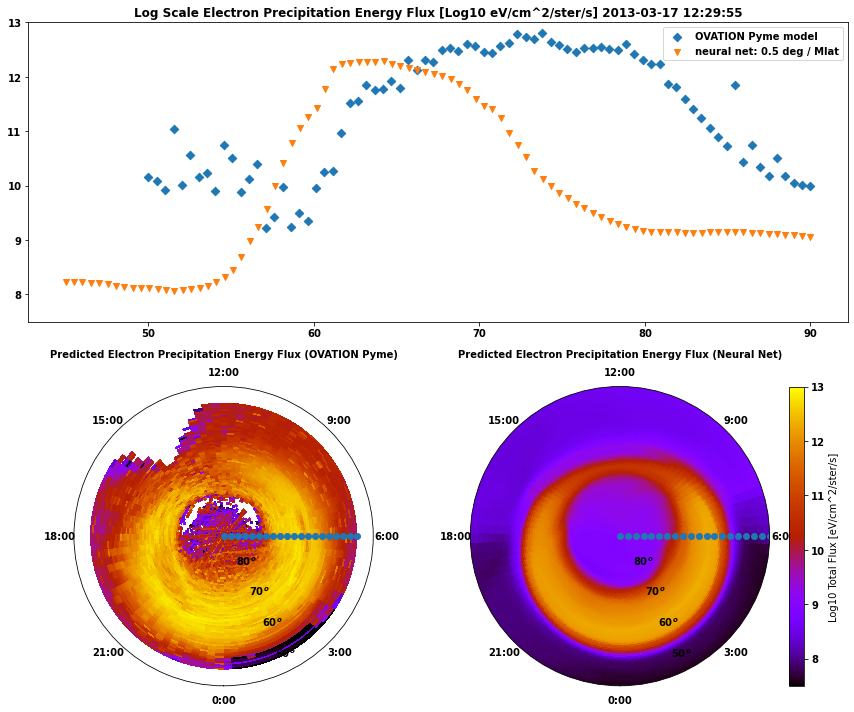

/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


2013-03-17 17:47:36
Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:434: RuntimeWarning: divide by zero encountered in log10


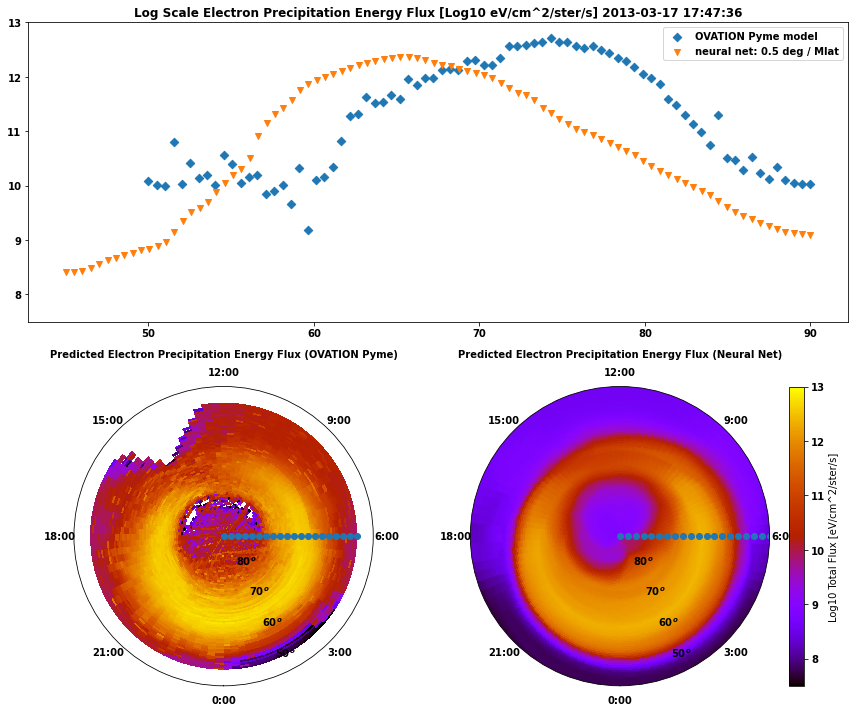

/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


2013-03-17 23:32:48
Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:434: RuntimeWarning: divide by zero encountered in log10


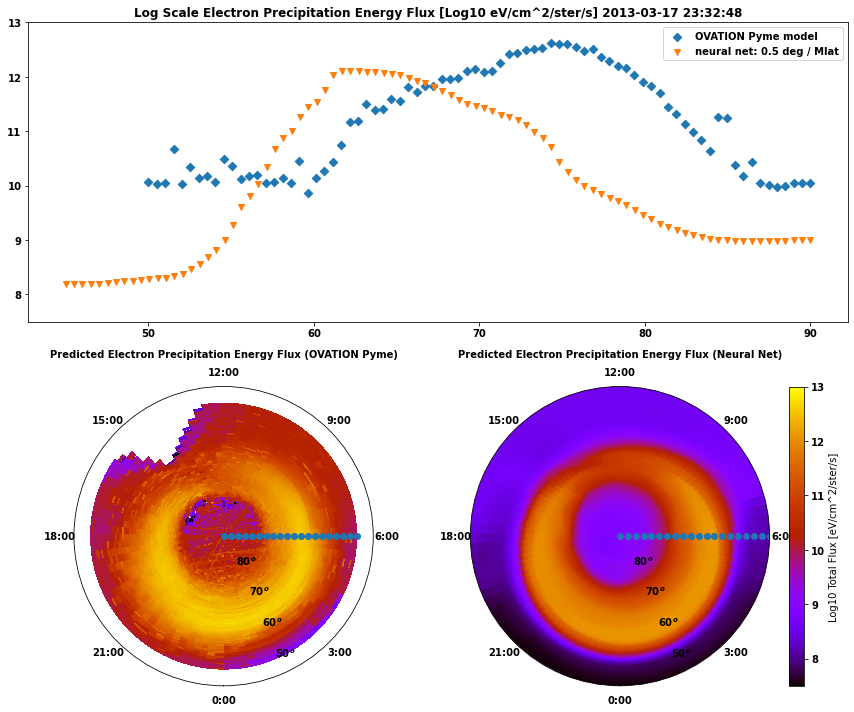

In [7]:
test_6_hour = test[1:60*60*24:60*60*3]
print(test_6_hour.shape)
plot_hemisphere(scaler_X, model, features, test_6_hour)

In [13]:
test120 = test[1:60*60*24:120]

results_ovation = plot_hemisphere2(scaler_X, model, features, test)

KeyboardInterrupt: 

In [10]:
results_ovation

NameError: name 'results_ovation' is not defined

In [15]:
plot_hemisphere3(scaler_X, model, features, test120)

/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:738: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ovationpyme-0.1.0-py3.6.egg/ovationpyme/ovation_plotting.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(thetagrid,rgrid,fluxgrid,**pcolor_kwargs)


Correction Applied
Correction Applied
Correction Applied


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:738: RuntimeWarning: divide by zero encountered in log10


KeyboardInterrupt: 

In [17]:
def custom_loss(y_true, y_pred):
    

    loss = K.mean( 
        2.5*(y_true-y_pred)*(y_true-y_pred)
        *K.cast(K.greater(y_true,6.25),'float32')*K.cast(K.less_equal(y_pred,6.25),'float32') +
        5*(y_true-y_pred)*(y_true-y_pred) 
        *K.cast(K.greater(y_true,6.75),'float32')*K.cast(K.less_equal(y_pred,6.75),'float32') +
        10*(y_true-y_pred)*(y_true-y_pred)
        *K.cast(K.greater(y_true,7),'float32')*K.cast(K.less_equal(y_pred,7),'float32')  
        +
        10*(y_true-y_pred)*(y_true-y_pred)
        *K.cast(K.greater(y_true,7.25),'float32')*K.cast(K.less_equal(y_pred,7.25),'float32')  
        +
        10*(y_true-y_pred)*(y_true-y_pred)
        *K.cast(K.greater(y_true,7.5),'float32')*K.cast(K.less_equal(y_pred,7.5),'float32')  
    )             
                 
            
    loss =  loss+K.mean((y_true-y_pred)*(y_true-y_pred))

    return loss

filename='counts_tail_loss_new_pipeline_33'
model = tensorflow.keras.models.load_model(filename, custom_objects={'custom_loss': custom_loss})

print(model.evaluate(scaler_X.transform(test[features].values),np.log10(test['ELE_TOTAL_COUNTS'].values+1)))


1387/1387 [==============================] - 2s 1ms/step - loss: 1.1835 - mean_squared_error: 0.8176
[1.183457851409912, 0.8175991773605347]


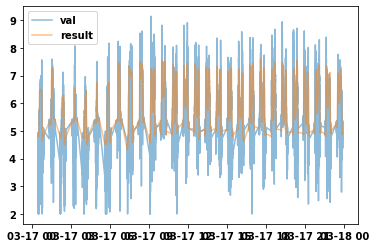

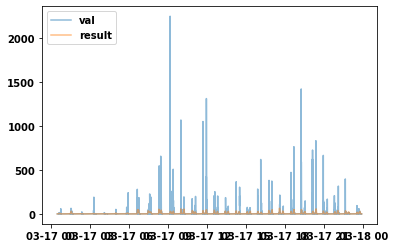

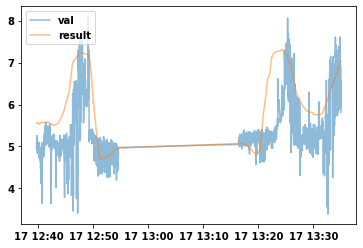

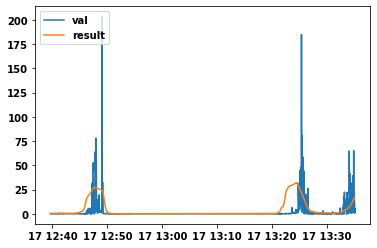

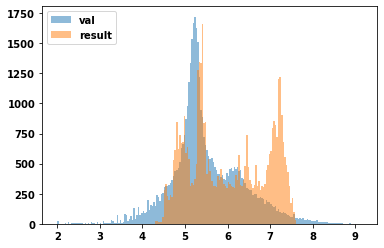

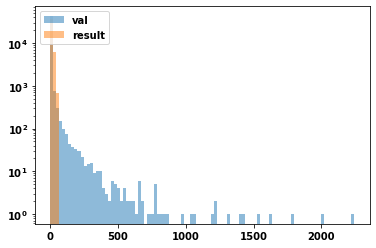

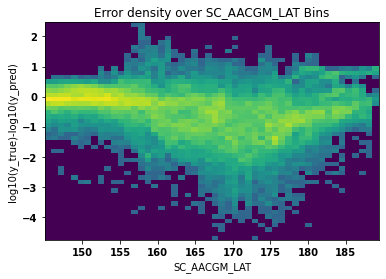

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide


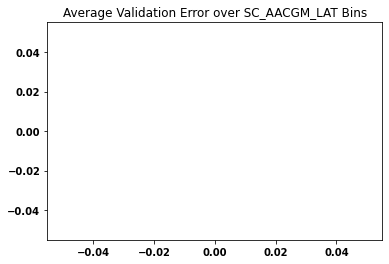

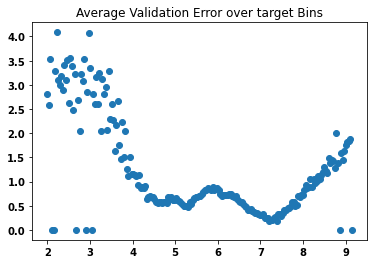

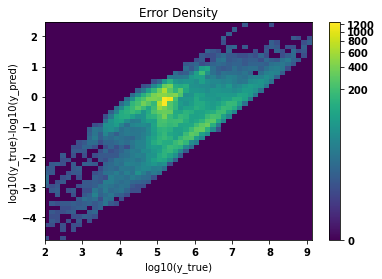

In [18]:
results_counts = model.predict( scaler_X.transform(test[features].values))
df_results = pd.DataFrame(data=results_counts, index = test.index)

# plot_model_counts(df_results, test.drop( test.index[(test['ELE_TOTAL_COUNTS']) < 3]))
plot_model_counts(df_results, test+100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


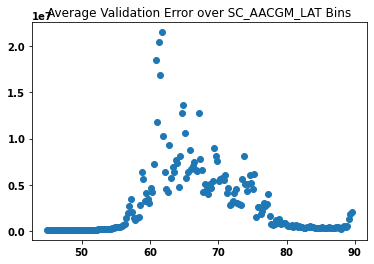

In [19]:
y_val_log = test['ELE_TOTAL_COUNTS']
errors= y_val_log.values-df_results.values[:,0]
plt.figure()
bin_total = np.zeros((200))
bin_error_total = np.zeros((200))
for j in range(0,y_val_log.values.shape[0]):
    i = int((test['SC_AACGM_LAT'].values[j]-45)/((90-45)/200))
    if i < 200:
        bin_total[i] = bin_total[i]+1
        bin_error_total[i] = bin_error_total[i] + np.abs(errors[j])

avg_error_over_hist = bin_error_total/bin_total
plt.scatter(np.linspace(45,90,num=200),avg_error_over_hist)
plt.title('Average Validation Error over SC_AACGM_LAT Bins')
plt.show()

In [20]:
def custom_loss(y_true, y_pred):
    

    loss = K.mean( 
        +
        2.5*(y_true-y_pred)*(y_true-y_pred)
        *K.cast(K.greater(y_true,2.66),'float32')*K.cast(K.less_equal(y_pred,2.66),'float32')  
        +
        10*(y_true-y_pred)*(y_true-y_pred)
        *K.cast(K.greater(y_true,3.),'float32')*K.cast(K.less_equal(y_pred,3.),'float32')  
                +
        10*(y_true-y_pred)*(y_true-y_pred)
        *K.cast(K.greater(y_true,3.5),'float32')*K.cast(K.less_equal(y_pred,3.33),'float32')  
    )             
                 
            
    loss =  loss+K.mean((y_true-y_pred)*(y_true-y_pred))

    return loss

filename='channel_counts_tail_loss_new_pipeline_33'
model = tensorflow.keras.models.load_model(filename, custom_objects={'custom_loss': custom_loss})

print(model.evaluate(scaler_X.transform(test[features].values),np.log10(test[['ELE_COUNT_1','ELE_COUNT_2', 'ELE_COUNT_3', 'ELE_COUNT_4', 'ELE_COUNT_5', 'ELE_COUNT_6', 'ELE_COUNT_7', 'ELE_COUNT_8', 'ELE_COUNT_9', 'ELE_COUNT_10', 'ELE_COUNT_11', 'ELE_COUNT_12', 'ELE_COUNT_13', 'ELE_COUNT_14', 'ELE_COUNT_15', 'ELE_COUNT_16', 'ELE_COUNT_17', 'ELE_COUNT_18', 'ELE_COUNT_19']].values+100)))

results_channels = model.predict( scaler_X.transform(test[features].values))
df_results = pd.DataFrame(data=results_channels, index = test.index)

1387/1387 [==============================] - 2s 1ms/step - loss: 2.4081 - mean_squared_error: 2.2006
[2.4080820083618164, 2.2006123065948486]


0


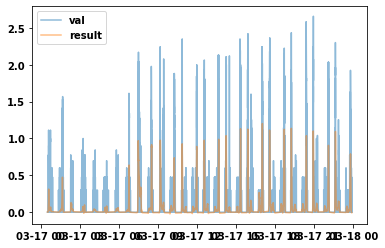

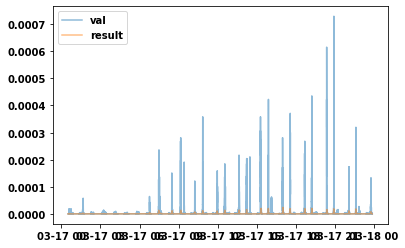

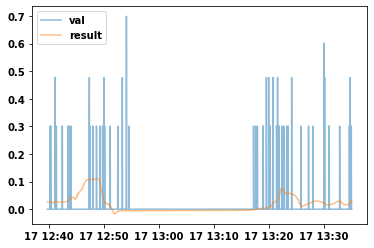

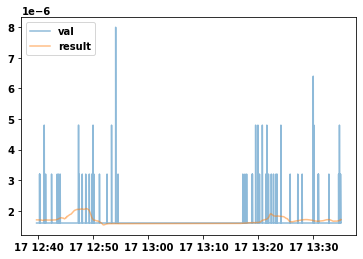

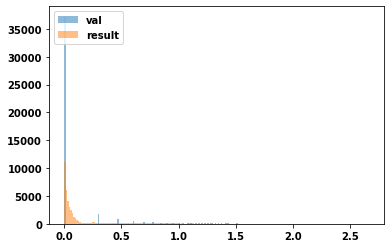

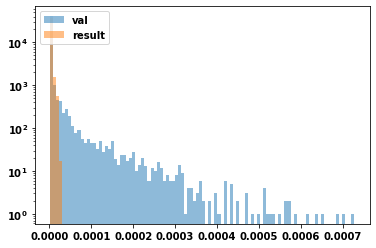

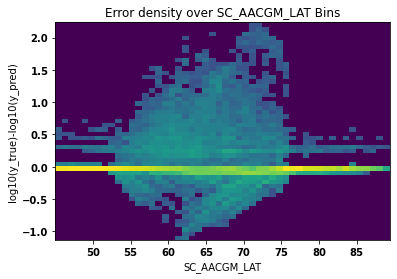

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: RuntimeWarning: invalid value encountered in true_divide


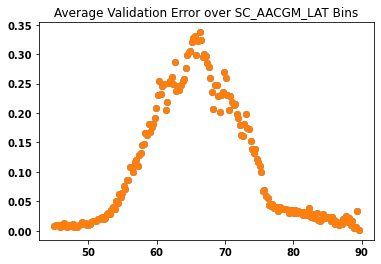

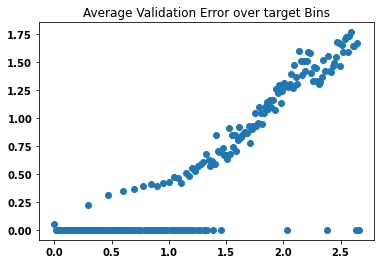

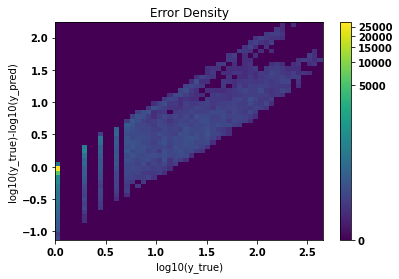

1


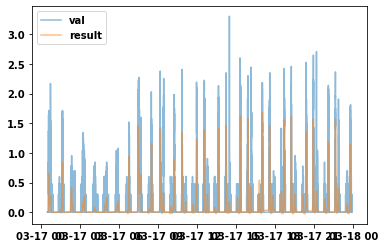

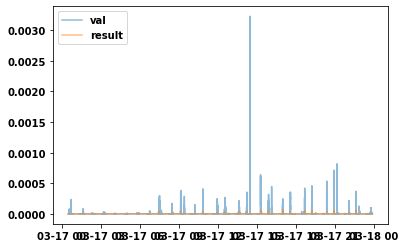

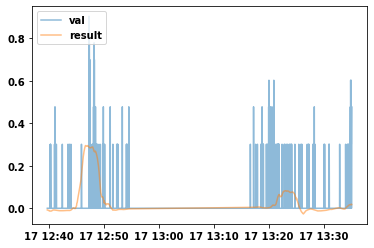

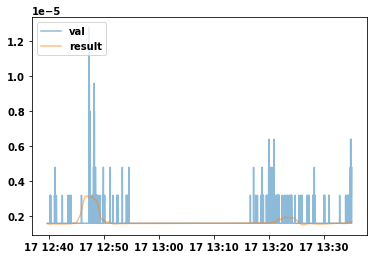

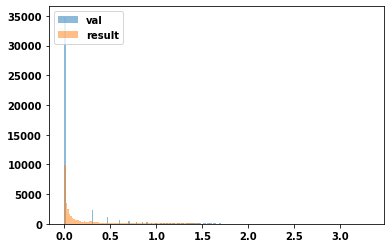

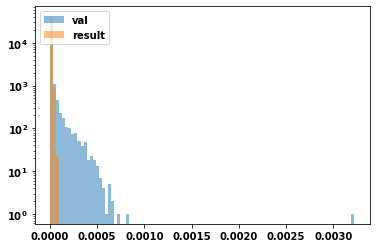

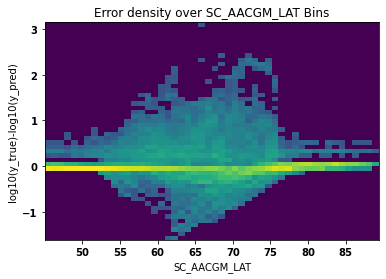

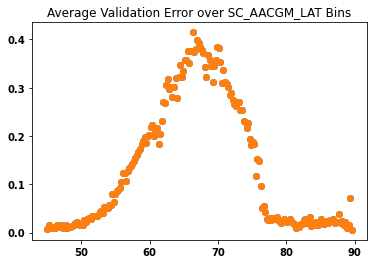

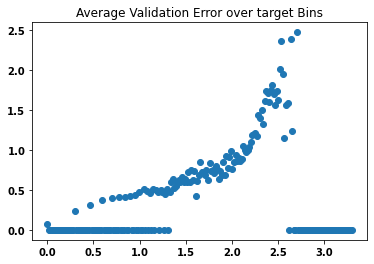

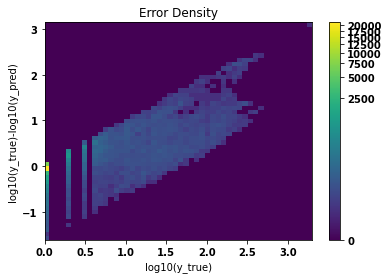

2


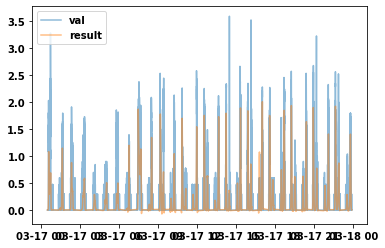

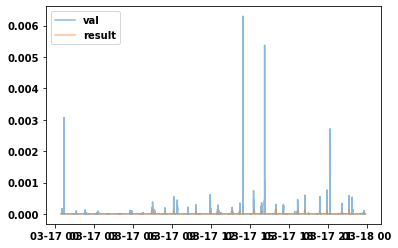

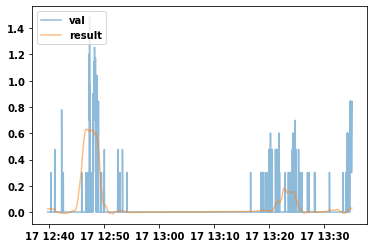

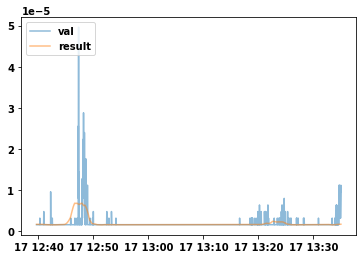

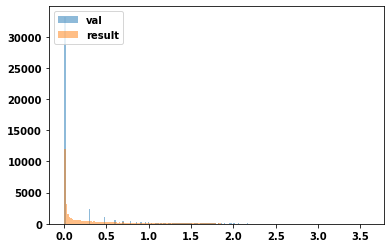

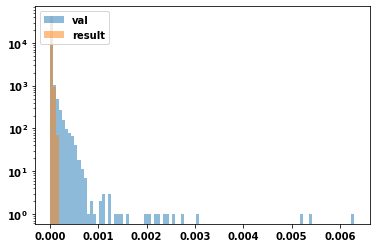

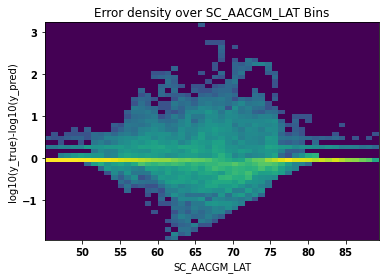

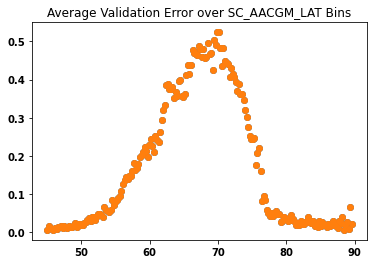

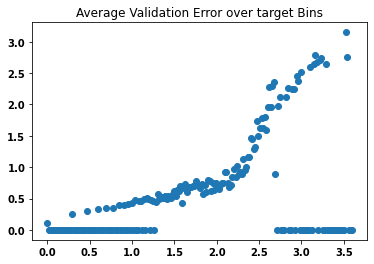

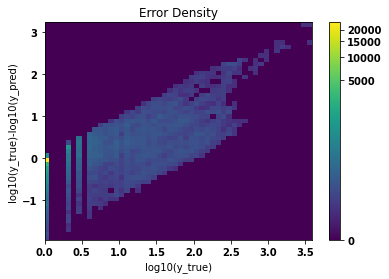

3


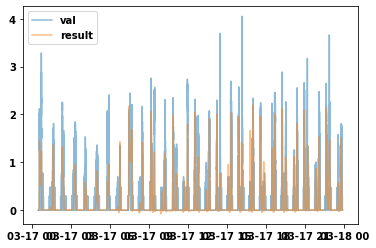

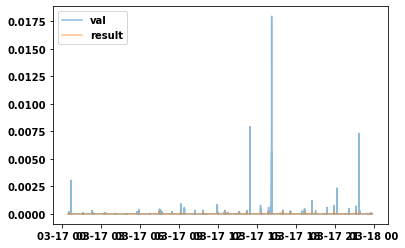

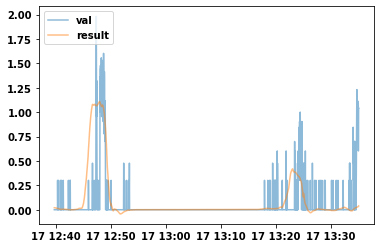

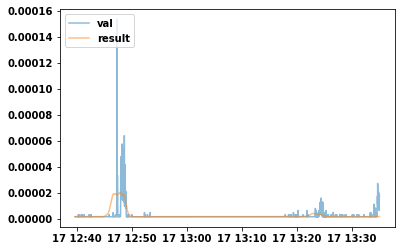

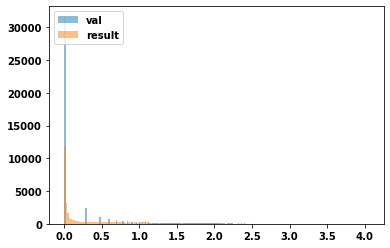

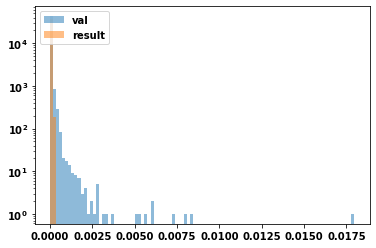

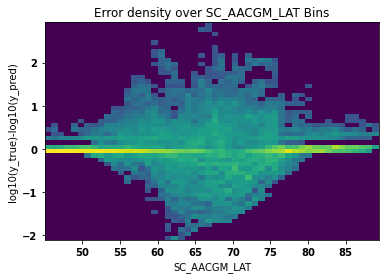

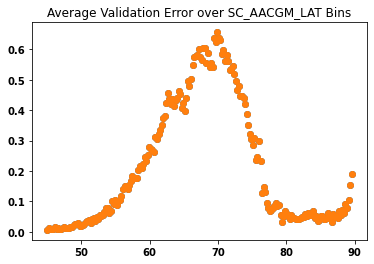

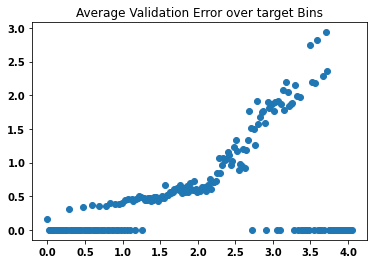

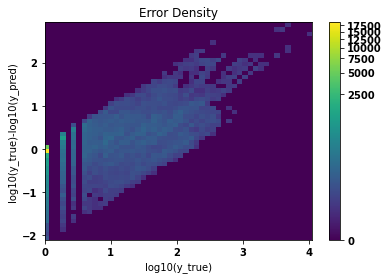

4


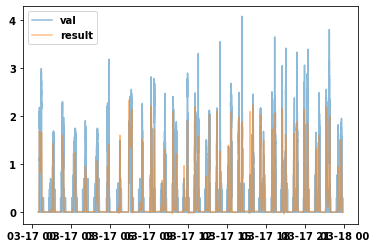

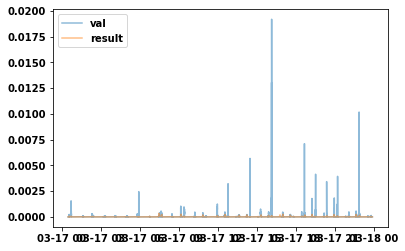

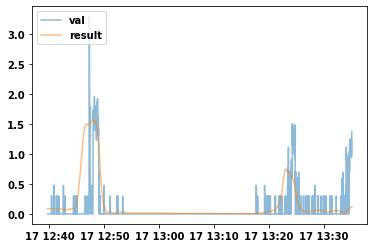

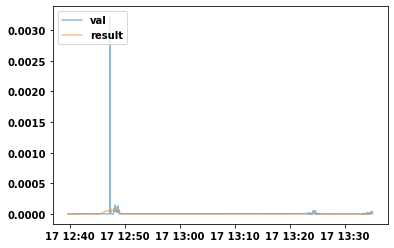

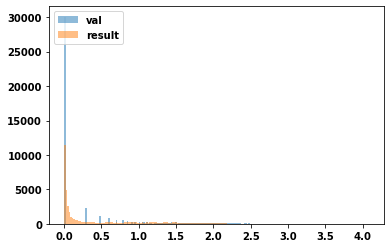

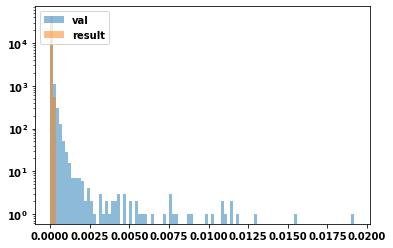

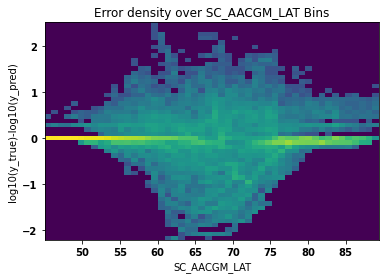

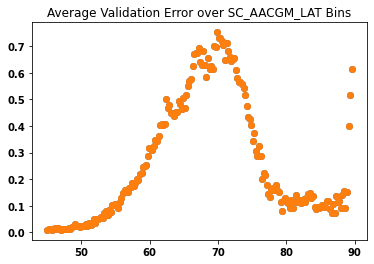

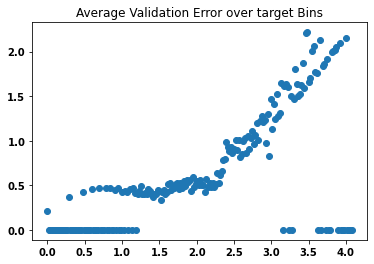

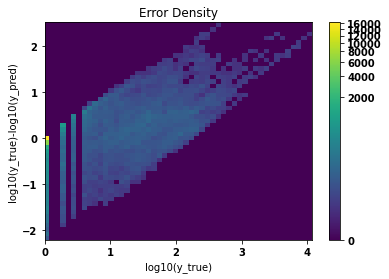

5


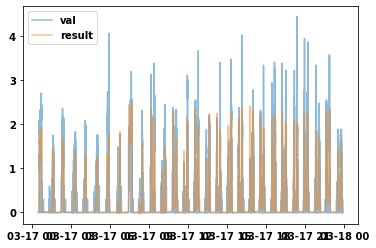

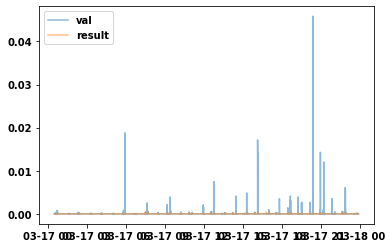

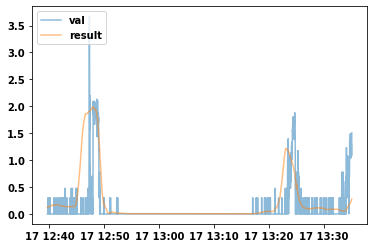

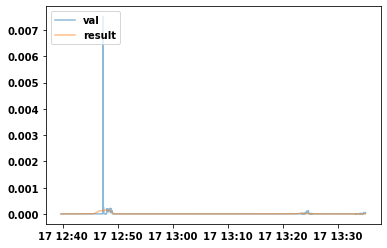

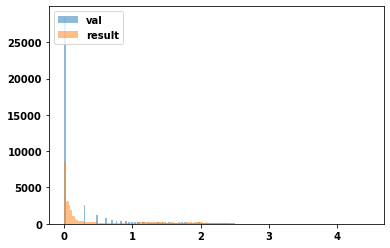

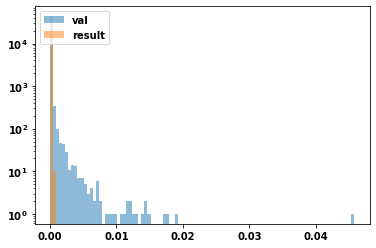

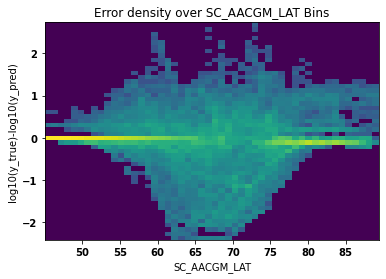

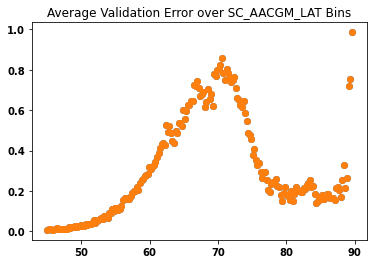

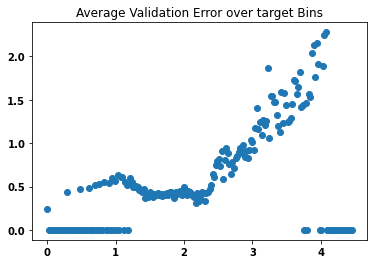

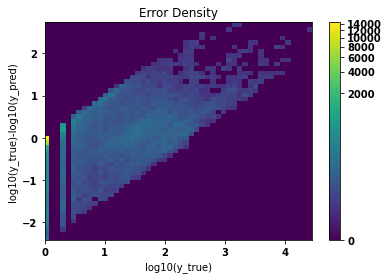

6


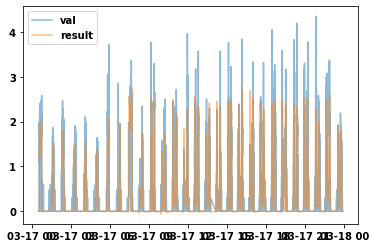

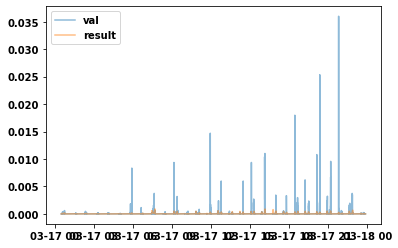

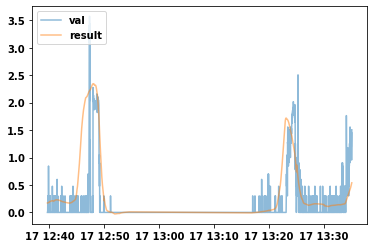

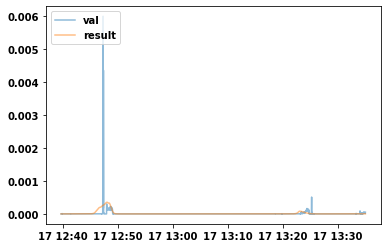

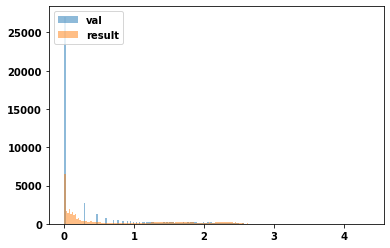

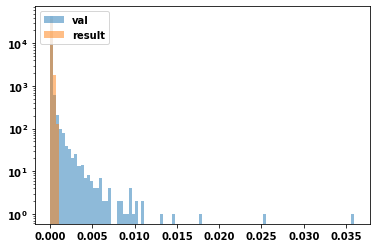

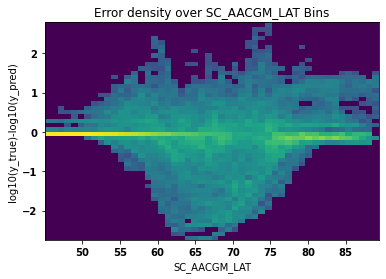

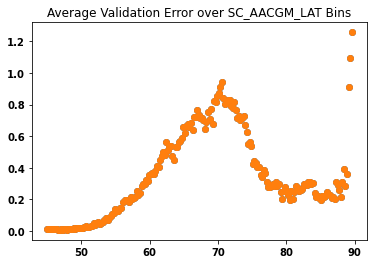

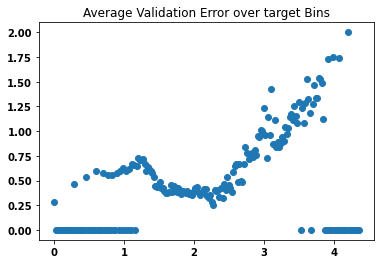

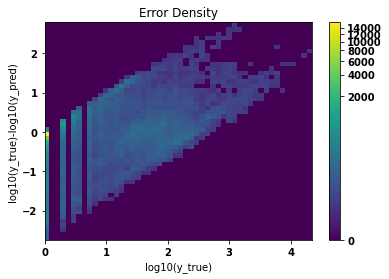

7


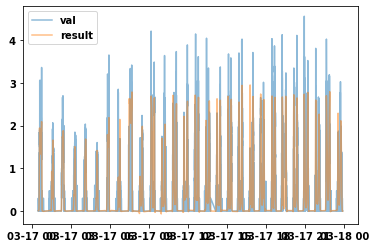

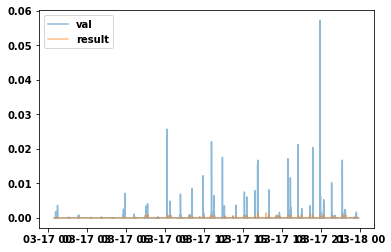

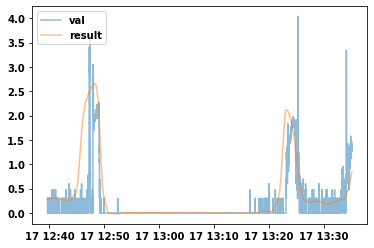

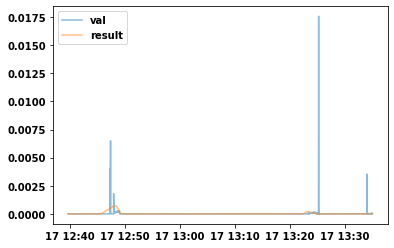

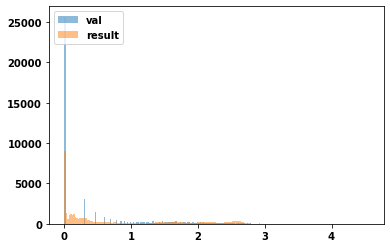

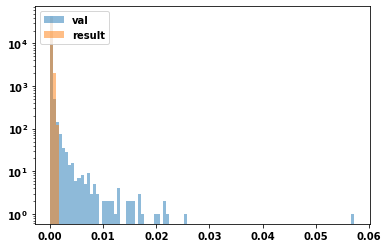

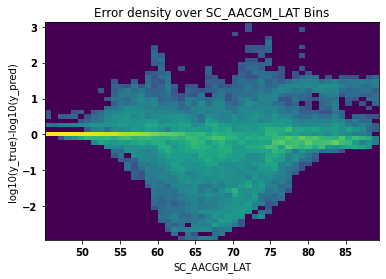

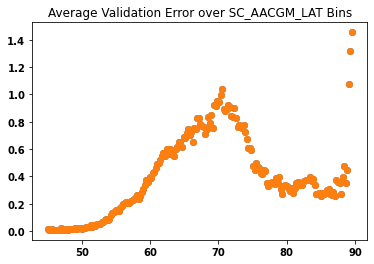

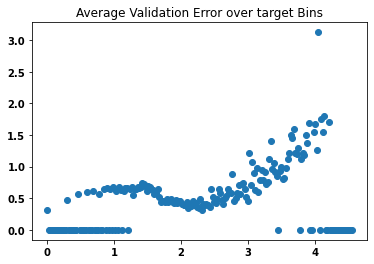

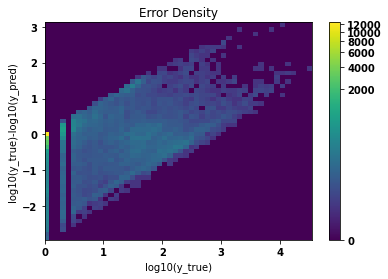

8


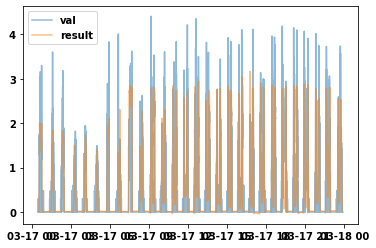

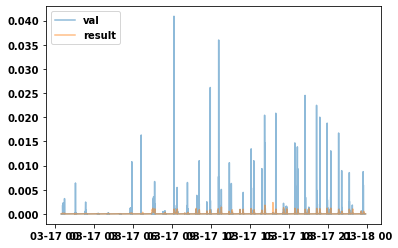

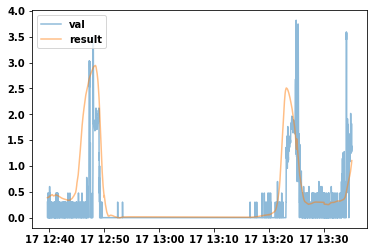

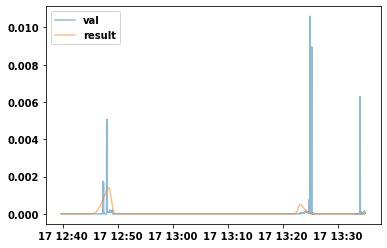

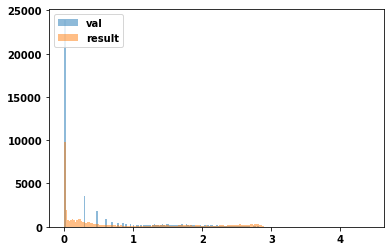

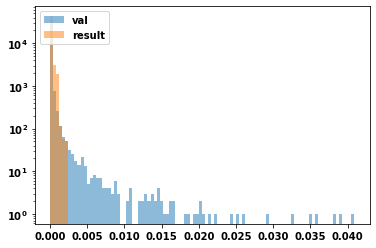

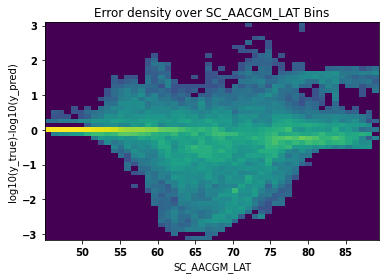

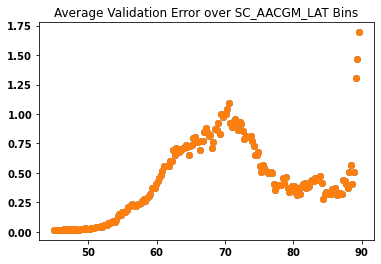

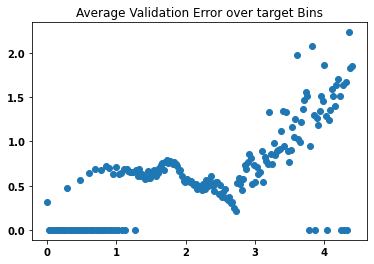

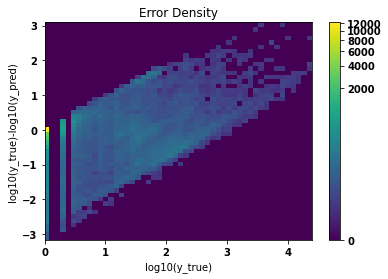

9


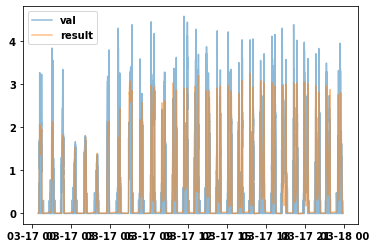

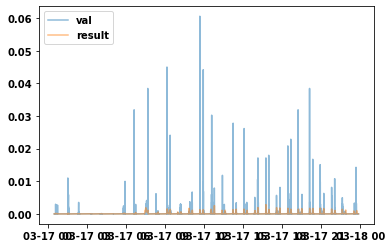

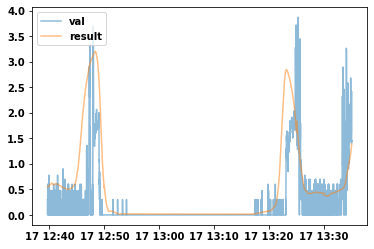

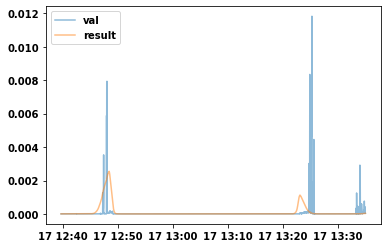

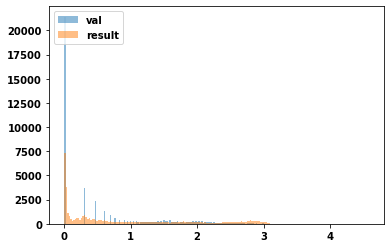

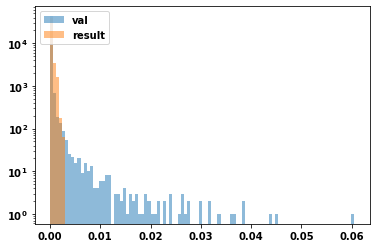

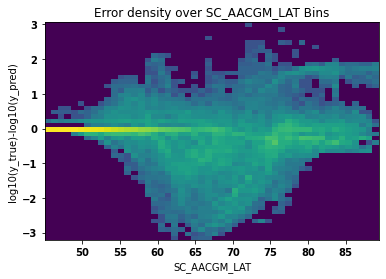

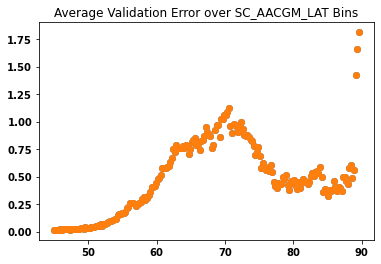

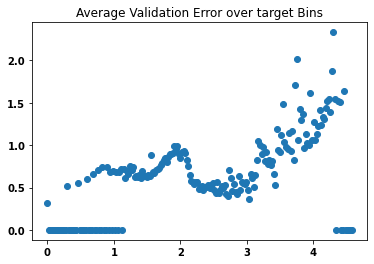

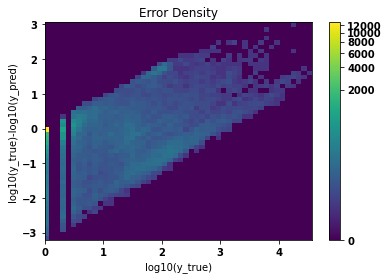

10


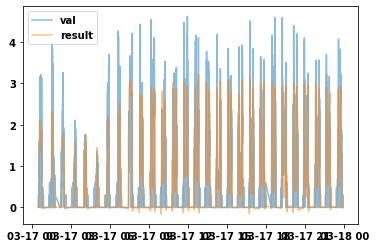

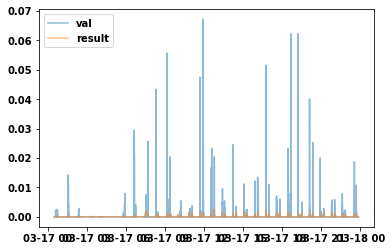

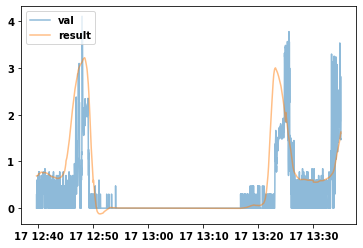

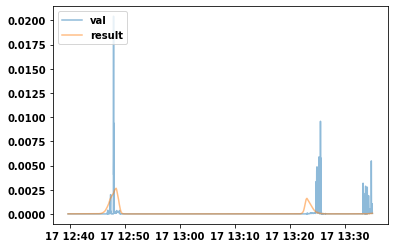

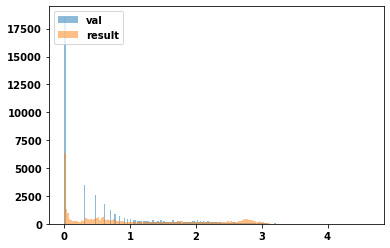

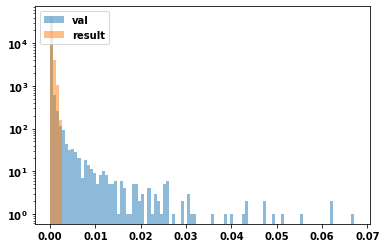

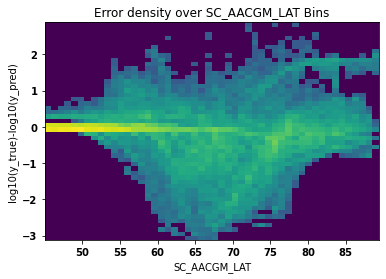

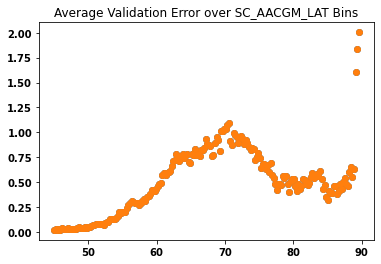

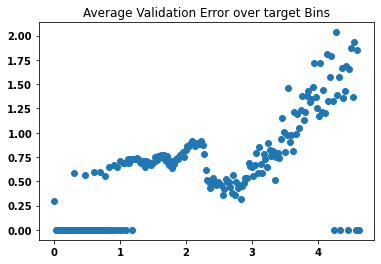

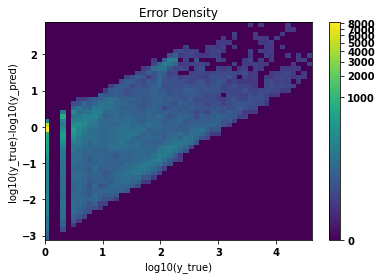

11


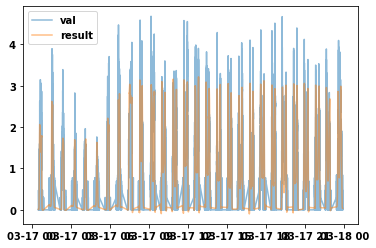

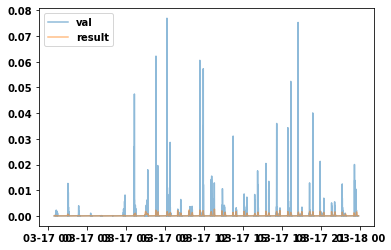

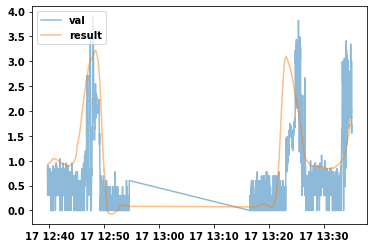

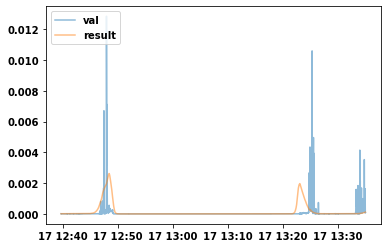

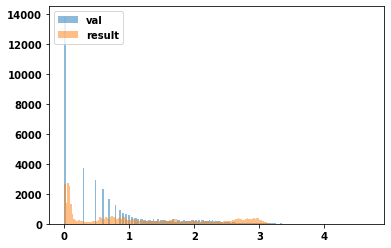

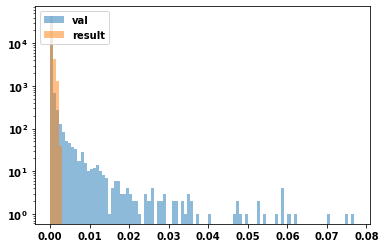

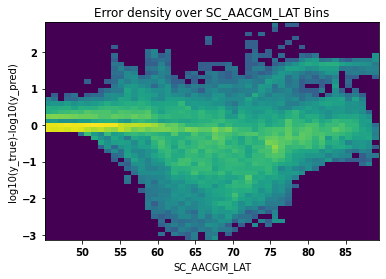

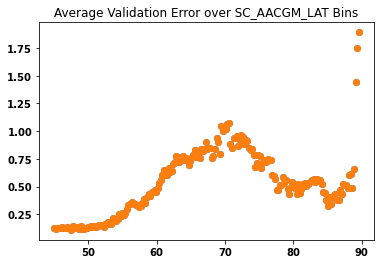

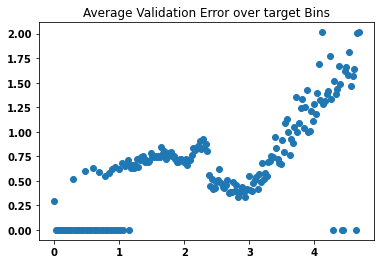

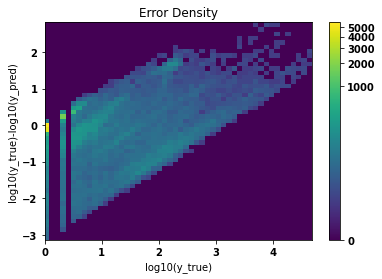

12


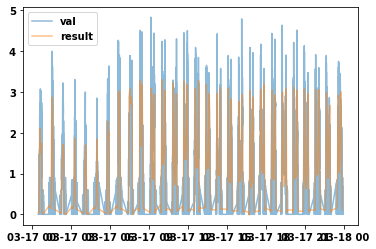

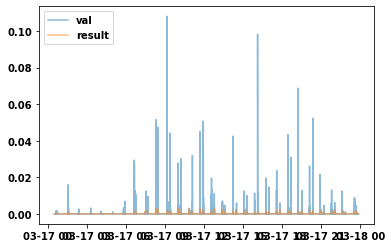

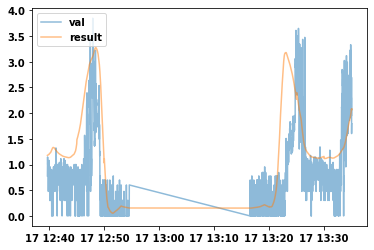

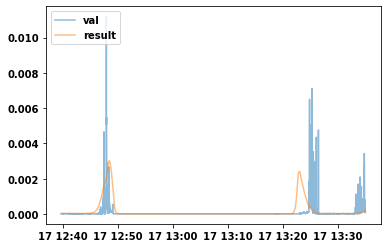

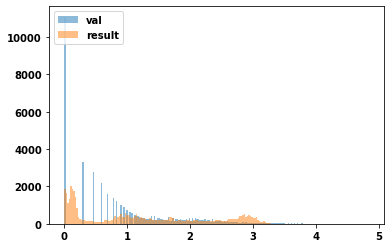

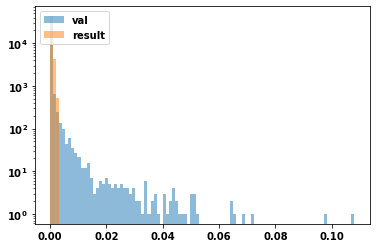

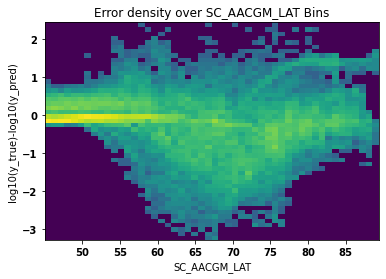

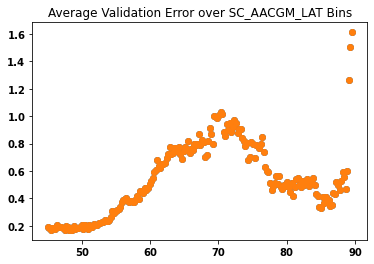

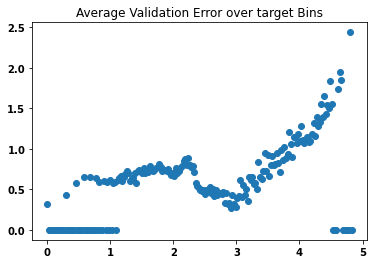

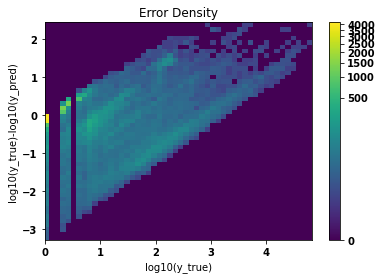

13


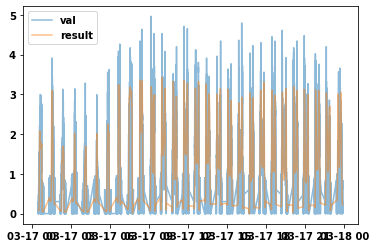

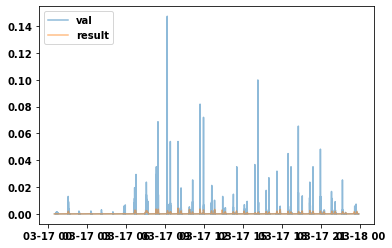

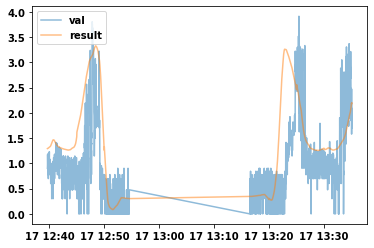

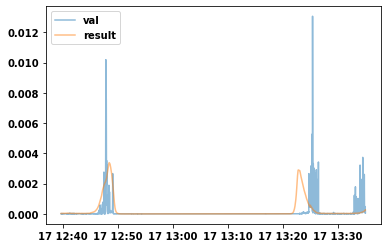

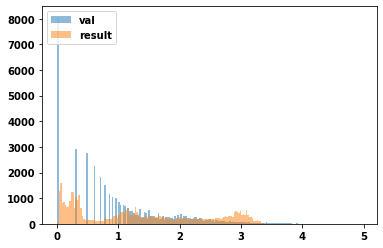

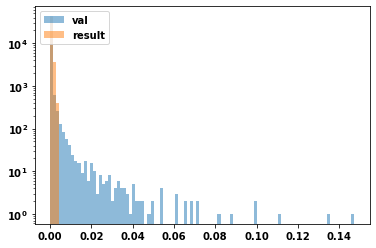

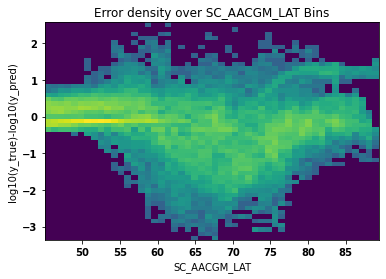

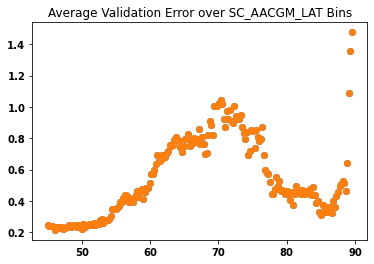

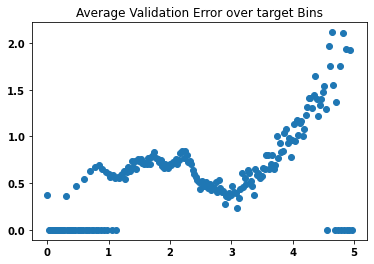

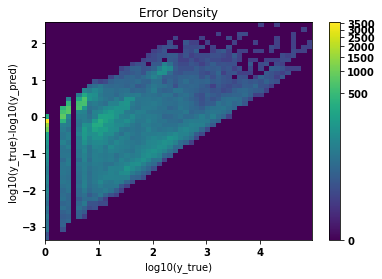

14


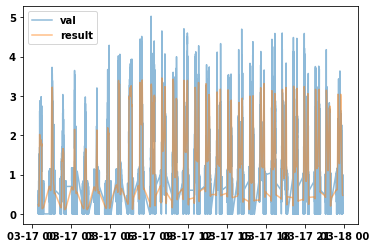

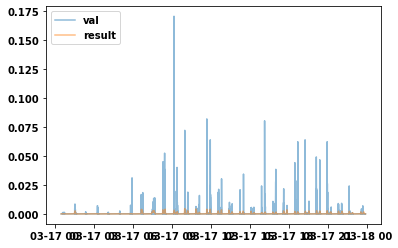

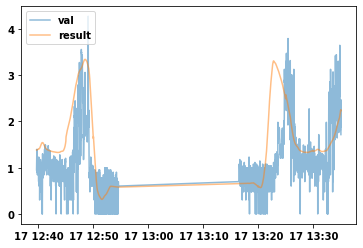

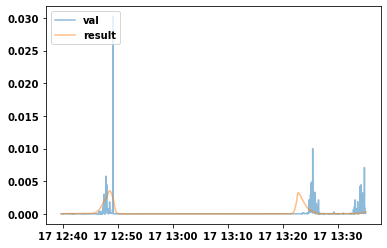

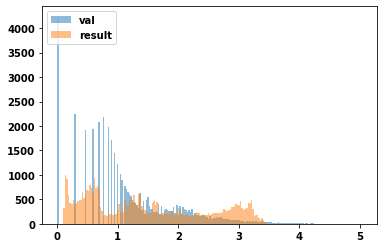

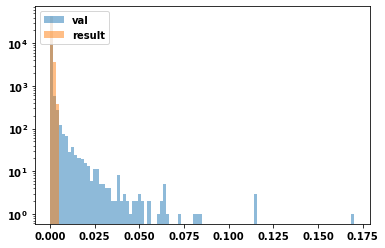

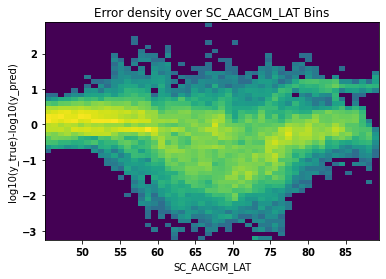

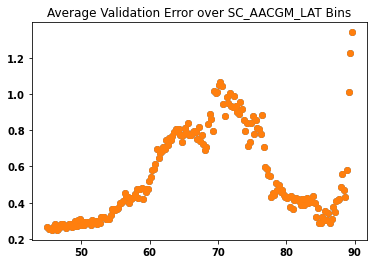

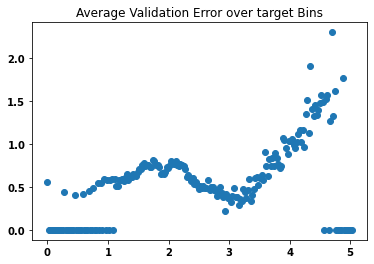

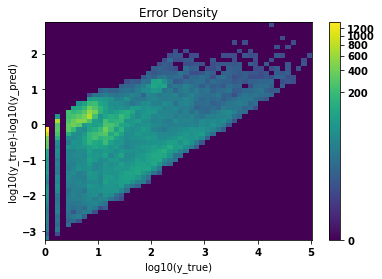

15


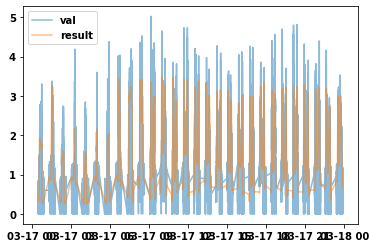

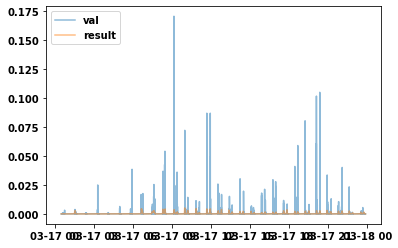

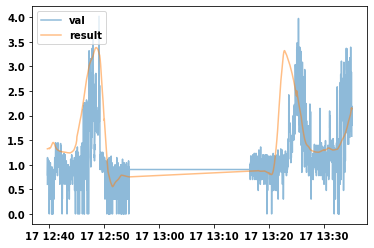

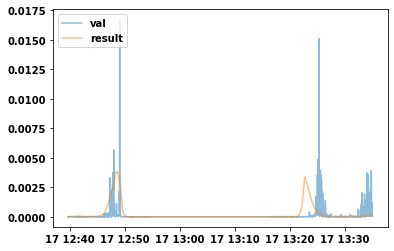

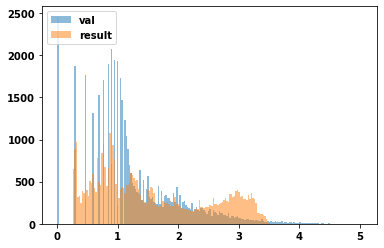

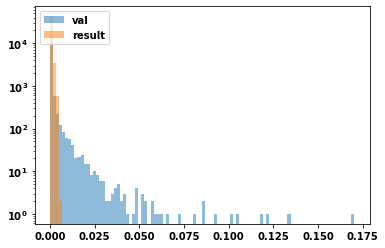

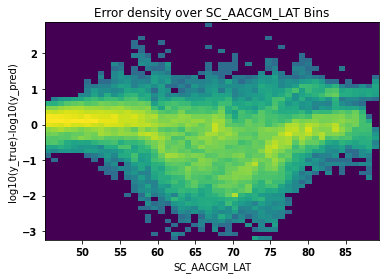

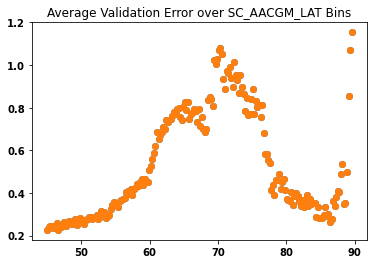

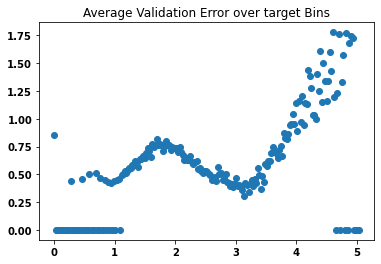

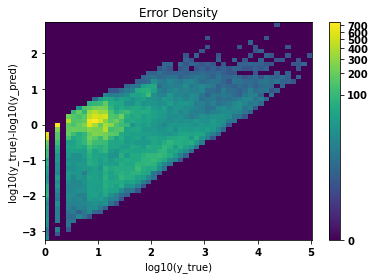

16


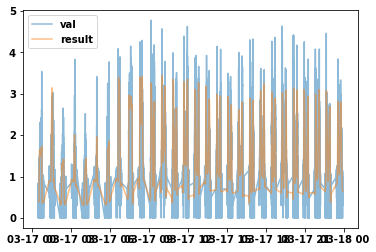

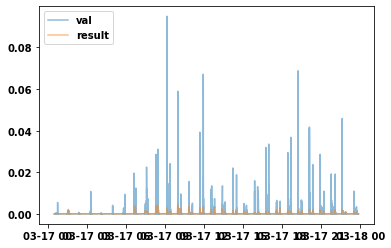

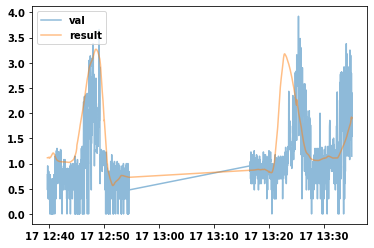

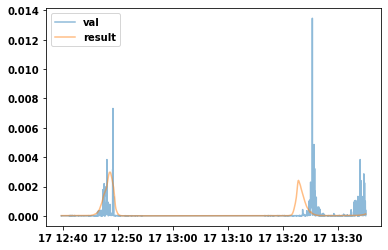

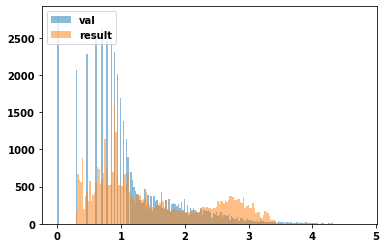

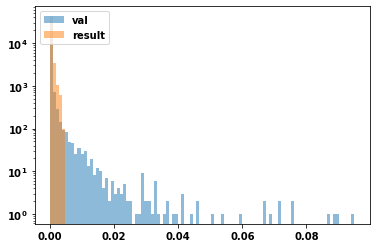

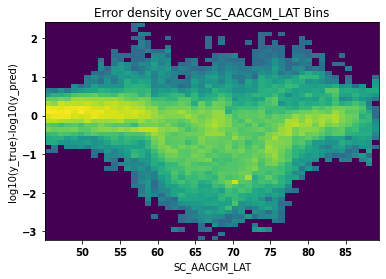

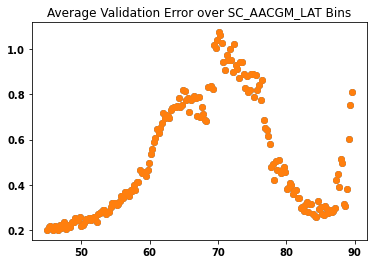

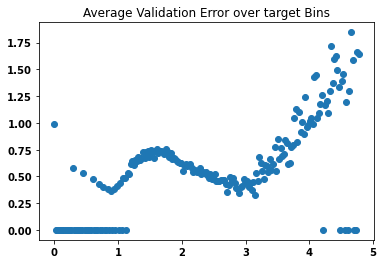

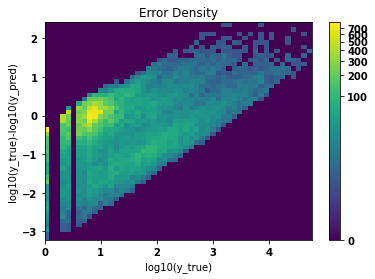

17


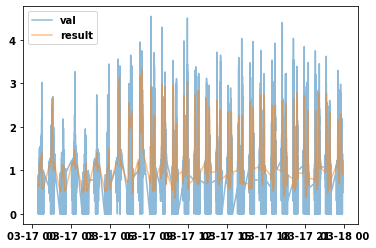

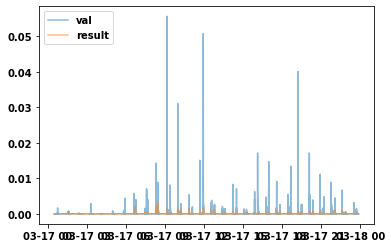

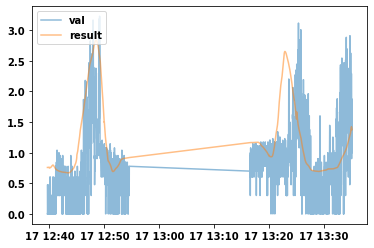

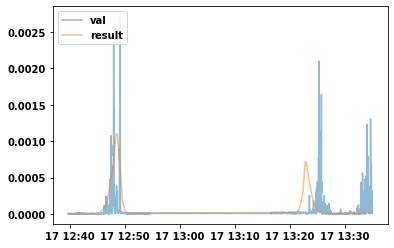

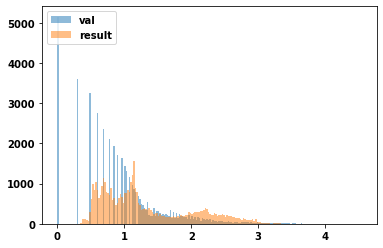

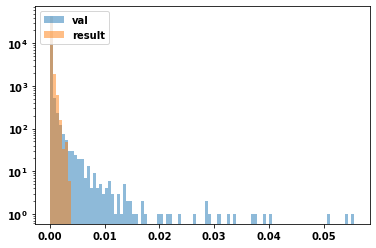

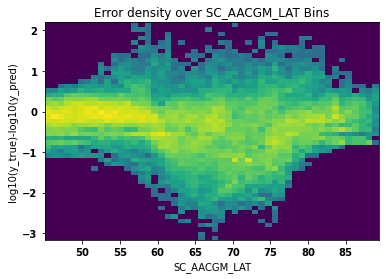

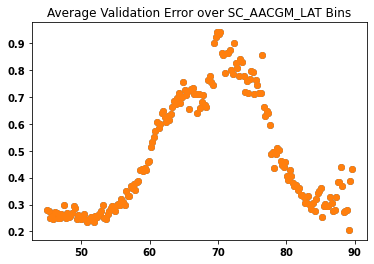

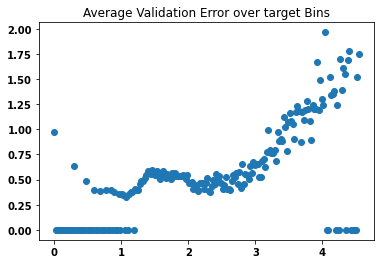

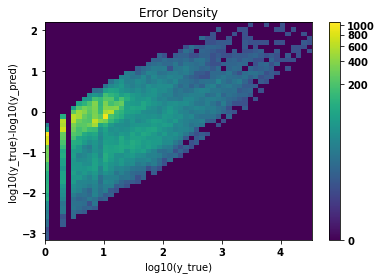

18


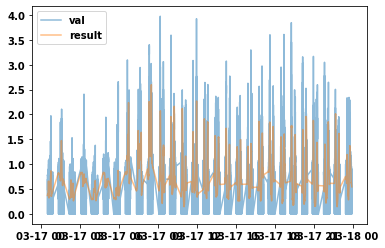

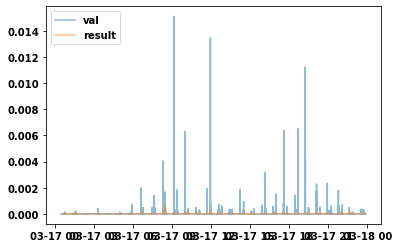

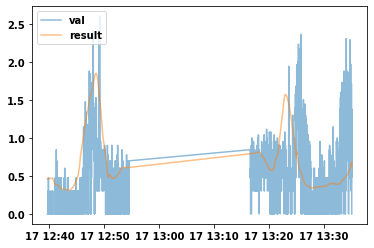

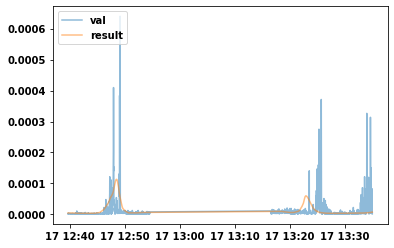

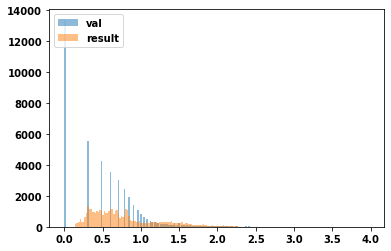

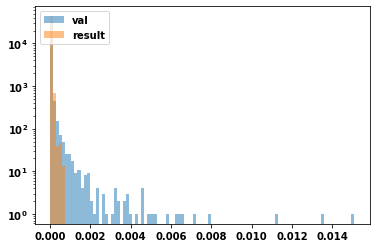

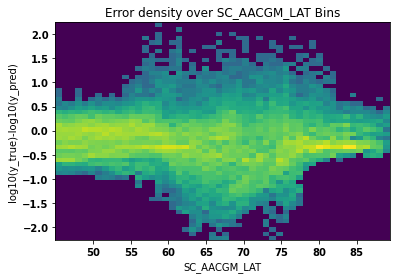

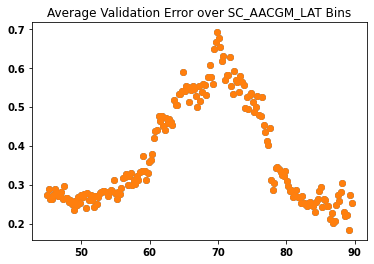

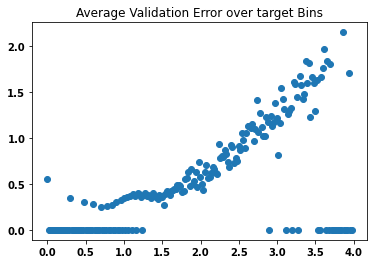

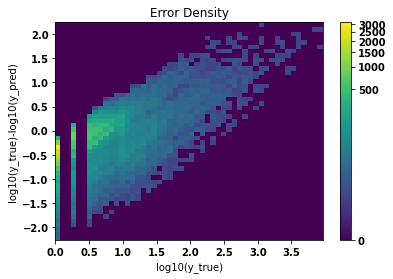

In [21]:
plot_channels(df_results,test)


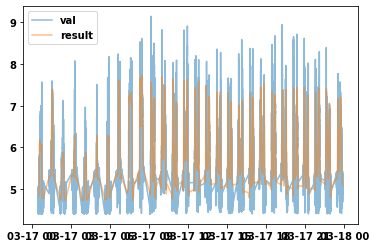

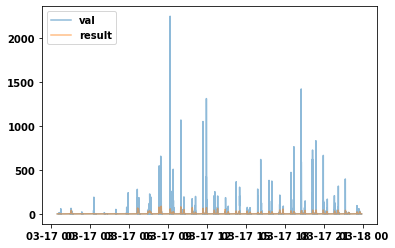

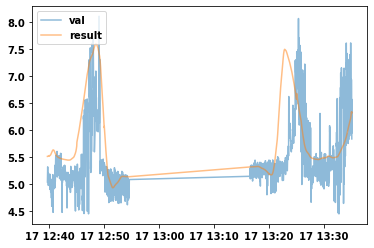

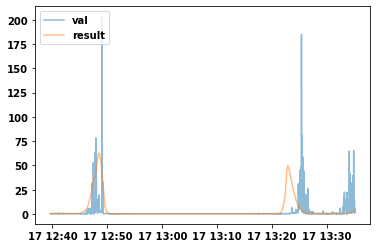

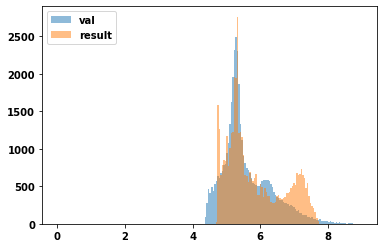

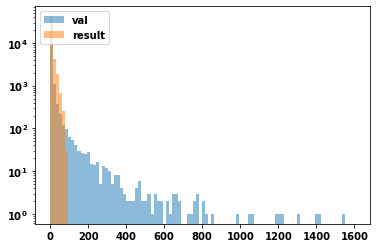

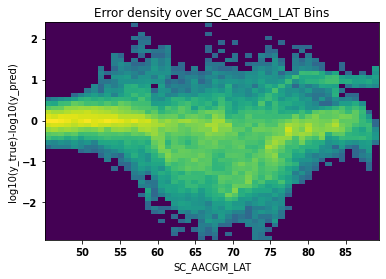

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in true_divide


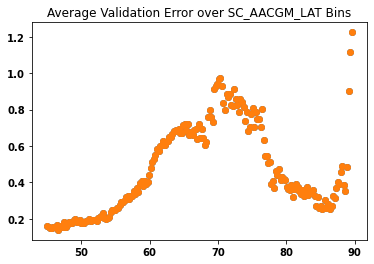

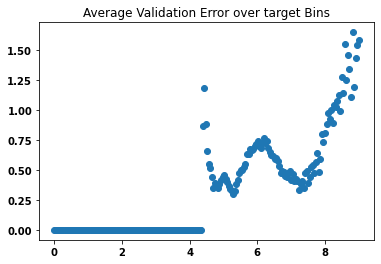

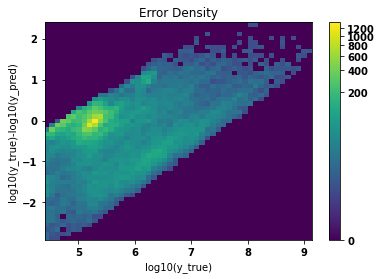

In [22]:
results_channel_total = plot_channels_total(df_results,test)

In [ ]:
CSV_dataframe = pd.DataFrame(data=[results_flux,results_counts,results_channels,results_channel_total,result_ovation],
     columns=['results_flux','results_counts','results_channels','results_channel_total','results_ovation'],
            index=test.index
                            )

CSV_dataframe.to_csv('results_march_17_2013_SC_ID_17.csv')
test.to_csv('data_march_17_2013_SC_ID_17.csv')

In [ ]:
test = get_data( datetime.datetime(2013, 3, 16),datetime.datetime(2013, 3, 17),16)
test =  pd.concat([test, get_data( datetime.datetime(2013, 3, 17),datetime.datetime(2013, 3, 17),17)])
test = pd.concat([test, get_data( datetime.datetime(2013, 3, 18),datetime.datetime(2013, 3, 17),18)])

test=test.dropna()

16
2013
lrwxrwxrwx   1 rcandey  cdaweb         18 Sep 26  2012 000_readme.txt -> /pub/000_readme.txt
lrwxrwxrwx   1 rcandey  cdaweb         18 May  5  2017 000test -> /pub/000_readme.txt
lrwxrwxrwx   1 rcandey  cdaweb         17 Oct  5  2018 datasets.json -> /pub/datasets.json
lrwxrwxrwx   1 tkovalic cdaweb         24 Sep 25  2012 filelist.gz -> /pub/catalogs/filelist.gz
lrwxrwxrwx   1 tkovalic cdaweb         30 Sep 25  2012 filelist.patch.gz -> /pub/catalogs/filelist.patch.gz
lrwxrwxrwx   1 tkovalic cdaweb         21 Sep 25  2012 ls-lR.gz -> /pub/catalogs/ls-lR.gz
lrwxrwxrwx   1 tkovalic cdaweb         27 Sep 25  2012 ls-lR.patch.gz -> /pub/catalogs/ls-lR.patch.gz
drwxrwxr-x  10 tkovalic cdaweb         14 Nov 10 11:56 pub
-rwxr-xr--   1 tkovalic cdaweb       1457 Sep 27  2019 robots.txt
created pub/data/dmsp/dmspf16
created pub/data/dmsp/dmspf16/ssj
created pub/data/dmsp/dmspf16/ssj/precipitating-electrons-ions
created pub/data/dmsp/dmspf16/ssj/precipitating-electrons-ions/2010
create

In [ ]:
                             
filename='tail_loss_new_pipeline_33'
model = tensorflow.keras.models.load_model(filename, custom_objects={'custom_loss': custom_loss})

with open ('scalar_X_33_new_DB.pkl', 'rb') as f:
    scaler_X =pickle.load(f)
print(model.evaluate(scaler_X.transform(test[features].values),np.log10(test['ELE_TOTAL_ENERGY_FLUX'].values+.0001)))
results_flux = model.predict( scaler_X.transform(test[features].values))
results_ovation = plot_hemisphere2(scaler_X, model, features, test)

filename='counts_tail_loss_new_pipeline_33'
model = tensorflow.keras.models.load_model(filename, custom_objects={'custom_loss': custom_loss})
print(model.evaluate(scaler_X.transform(test[features].values),np.log10(test['ELE_TOTAL_COUNTS'].values+1)))
results_counts = model.predict( scaler_X.transform(test[features].values))

filename='channel_counts_tail_loss_new_pipeline_33'
model = tensorflow.keras.models.load_model(filename, custom_objects={'custom_loss': custom_loss})
print(model.evaluate(scaler_X.transform(test[features].values),np.log10(test[['ELE_COUNT_1','ELE_COUNT_2', 'ELE_COUNT_3', 'ELE_COUNT_4', 'ELE_COUNT_5', 'ELE_COUNT_6', 'ELE_COUNT_7', 'ELE_COUNT_8', 'ELE_COUNT_9', 'ELE_COUNT_10', 'ELE_COUNT_11', 'ELE_COUNT_12', 'ELE_COUNT_13', 'ELE_COUNT_14', 'ELE_COUNT_15', 'ELE_COUNT_16', 'ELE_COUNT_17', 'ELE_COUNT_18', 'ELE_COUNT_19']].values+100)))
results_channels = model.predict( scaler_X.transform(test[features].values))

results_channel_total = plot_channels_total(df_results,test)

CSV_dataframe = pd.DataFrame(data=[results_flux,results_counts,results_channels,results_channel_total,result_ovation],
     columns=['results_flux','results_counts','results_channels','results_channel_total','results_ovation'],
            index=test.index
                            )
CSV_dataframe.to_csv('results_march_17_2013.csv')
test.to_csv('data_march_17_2013.csv')